<font size=5>

__What is the project and data about?__

<font size=3.5>    
I have got this data from one of my lectures at Gazi University. 
Data has date, product and sales attributes which is obtained from e-commercial website. 
Project is about ARMA and ARIMA model application in Python.
    
Selman Koral
BSc. Industrial Engineering -Gazi University

In [9]:
import pandas as pd
import numpy as np  
import matplotlib.pyplot as plt  
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 10]
from scipy.stats import norm
from scipy import stats
import datetime
from IPython.display import Image, HTML, display, Markdown

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

In [10]:
df = pd.read_csv('sales_of_goods.csv')
df['event_date'] = pd.to_datetime(df['event_date'])
df.rename(columns={'product':'product_name'}, inplace=True)
df['product_name'] = df['product_name'].apply(lambda row: str(row))
df['product_name'] = df['product_name'].astype('category')
df.sort_values(by=['product_name', 'event_date'], ascending=[True, True], inplace=True)
df.reset_index(drop=True, inplace=True)
df.head()

,event_date,sold_count,product_name
0,2019-04-30,0,Bikini_Top
1,2019-05-01,0,Bikini_Top
2,2019-05-02,0,Bikini_Top
3,2019-05-03,0,Bikini_Top
4,2019-05-04,0,Bikini_Top


In [11]:
df.isna().sum() # Checking if there is any empty rows.

event_date      0
sold_count      0
product_name    0
dtype: int64

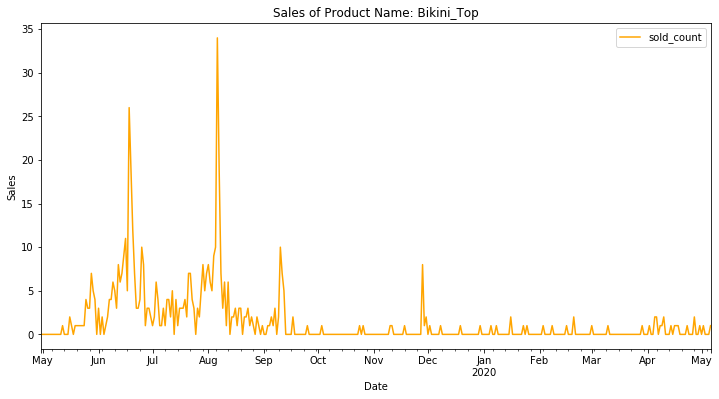

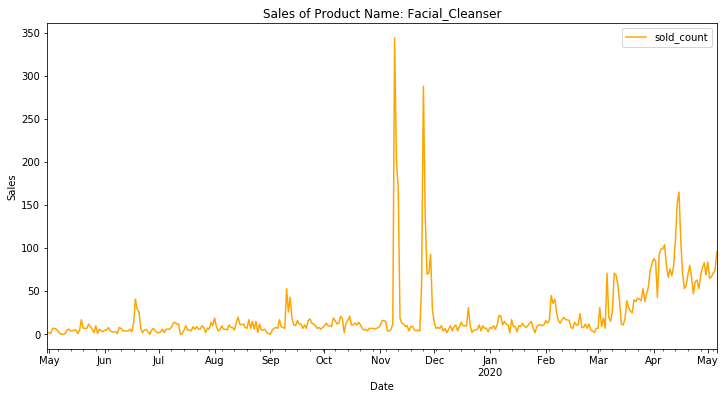

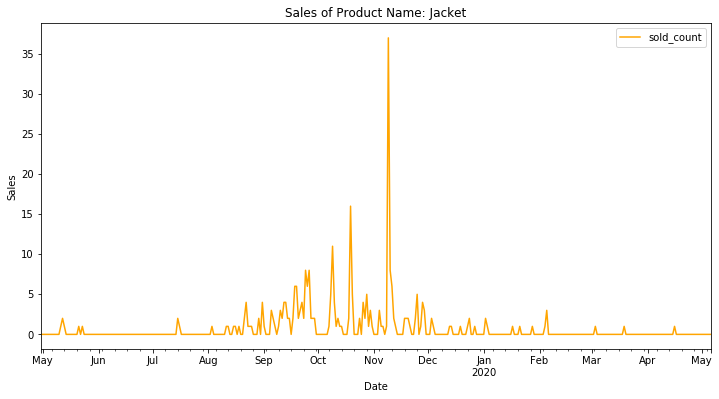

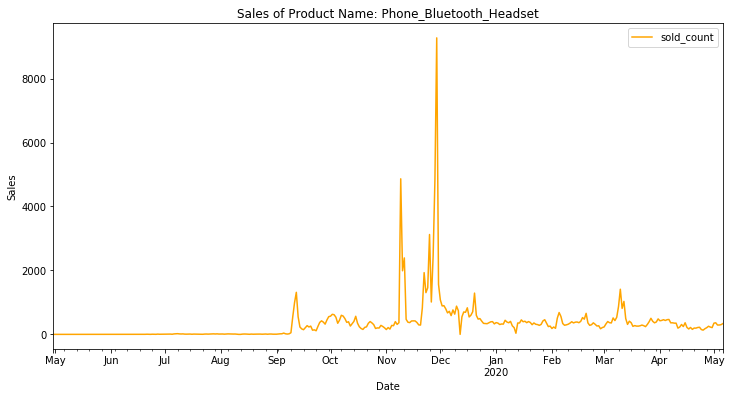

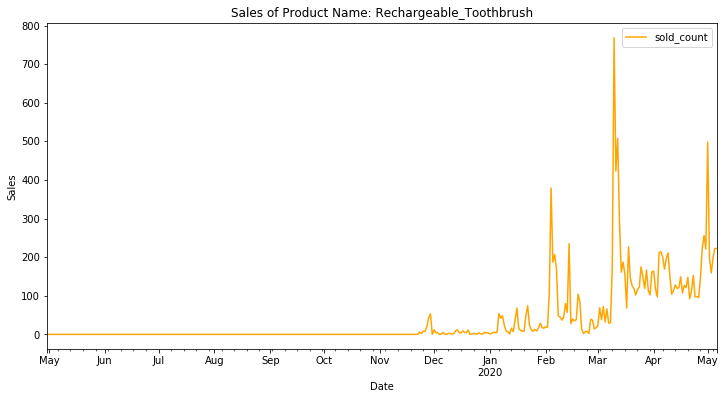

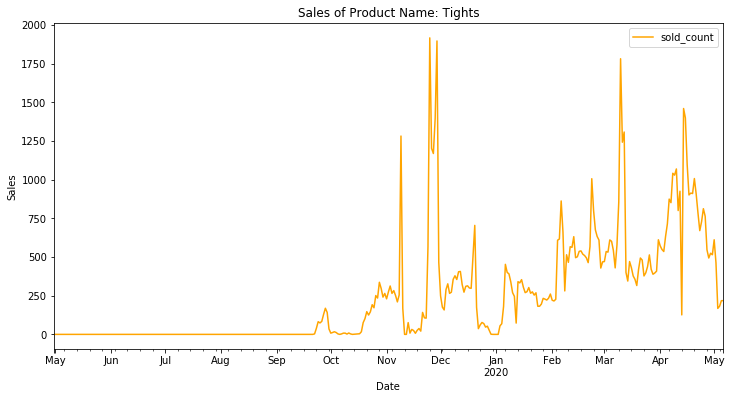

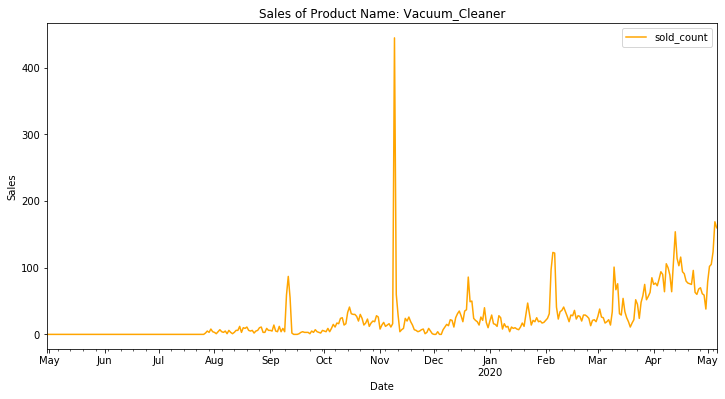

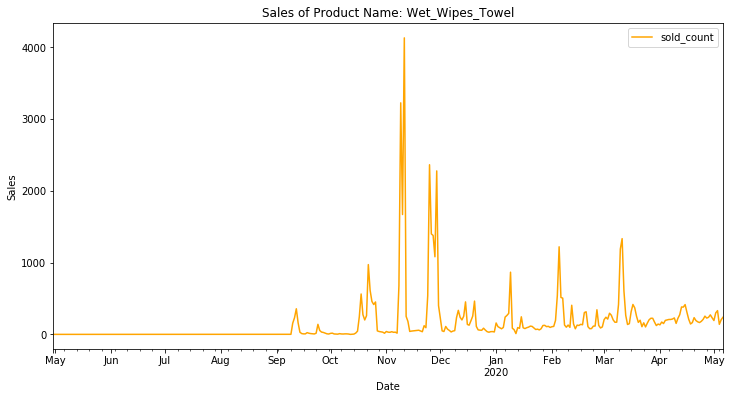

In [12]:
for i in list(df['product_name'].unique()):
    df.loc[df['product_name'] == i].plot(x='event_date', y=['sold_count'], title='Sales of Product Name: {}'.format(i), figsize=(12,6), c='orange')               
    plt.xlabel('Date')
    plt.ylabel('Sales')
    plt.show()

<font size = 3.5>

We can observe that, mean and variance of sales of products aren't constant. Each product has its seasonality periods. For example, Bikini top is sold most frequently in summer, Jacket is mostly sold in winter and autumn. And most of them has top sales in Black Friday (around December). Additionally, most of the graphs tell us that mean and variance of product sales are not constant. Data has an increasing trend and variance also increased year by year, when mean is increased. This suggests a multiplicative model. All things considered, the underlying model is not stationary time series. Before going into the models, I will define some functions to help me during analysis.

In [13]:
def plotprediction(series, pred_series, labels=["original", "predicted"], x_axis=None, plot_intervals=False, scale=1.96, plot_anomalies=False, title="prediction"):

    plt.figure(figsize=(15,5))
    plt.title(title)
    if x_axis is None:
        x_axis=series.index
    
    plt.plot(x_axis, pred_series, "g", label=labels[1])
    plt.plot(x_axis, series, label=labels[0])

    plt.legend(loc="upper left")
    plt.grid(True)

def timeseries_train_test_split_indexes(ts, test_size):
    split_time = int(len(ts)*(1-test_size))   
    test_index=ts.iloc[split_time:].index[0]
    return ts.index<test_index, ts.index>=test_index

def print_stats(y_test, y_preds, title="You forgot the title!"):
    print(title+": ")
    print("\tr^2=%f"%r2_score(y_test,y_preds))
    print("\tMAE=%f"%mean_absolute_error(y_test,y_preds))
    print("\tMAPE=%f"%mean_absolute_percentage_error(y_test,y_preds))
    
def train_test_index(name_list):
    for i in name_list:
        globals()['{}_train_ix'.format(str(i.name))], globals()['{}_test_ix'.format(str(i.name))] = timeseries_train_test_split_indexes(i, 0.2)

plotprediction() function plots the real data and predictions.  timeseries_train_test_split_indexes() function splits the indices of input dataframe as train and test data. print_stats() function evaluates the model regarding R^2, mean absolute error and mean absolute percentage error. In the further analysis there will be infinity values is mean absolute percentage error since there are products without sales in test data.

In [14]:
df_i = df.set_index('event_date')
df_i.index = pd.to_datetime(df_i.index)

Facial_Cleanser = df_i.loc[(df_i.product_name == 'Facial_Cleanser')]['sold_count'].copy()
Facial_Cleanser = pd.DataFrame(Facial_Cleanser); Facial_Cleanser.name = 'Facial_Cleanser'

Vacuum_Cleaner = df_i.loc[(df_i.product_name == 'Vacuum_Cleaner')]['sold_count'].copy()
Vacuum_Cleaner = pd.DataFrame(Vacuum_Cleaner); Vacuum_Cleaner.name = 'Vacuum_Cleaner'

Phone_Bluetooth_Headset = df_i.loc[(df_i.product_name == 'Phone_Bluetooth_Headset')]['sold_count'].copy()
Phone_Bluetooth_Headset = pd.DataFrame(Phone_Bluetooth_Headset); Phone_Bluetooth_Headset.name = 'Phone_Bluetooth_Headset'

Bikini_Top = df_i.loc[(df_i.product_name == 'Bikini_Top')]['sold_count'].copy()
Bikini_Top = pd.DataFrame(Bikini_Top); Bikini_Top.name = 'Bikini_Top'

Wet_Wipes_Towel = df_i.loc[(df_i.product_name == 'Wet_Wipes_Towel')]['sold_count'].copy()
Wet_Wipes_Towel = pd.DataFrame(Wet_Wipes_Towel); Wet_Wipes_Towel.name = 'Wet_Wipes_Towel'

Jacket = df_i.loc[(df_i.product_name == 'Jacket')]['sold_count'].copy()
Jacket = pd.DataFrame(Jacket); Jacket.name = 'Jacket'

Rechargeable_Toothbrush = df_i.loc[(df_i.product_name == 'Rechargeable_Toothbrush')]['sold_count'].copy()
Rechargeable_Toothbrush = pd.DataFrame(Rechargeable_Toothbrush); Rechargeable_Toothbrush.name = 'Rechargeable_Toothbrush'

Tights = df_i.loc[(df_i.product_name == 'Tights')]['sold_count'].copy()
Tights = pd.DataFrame(Tights); Tights.name = 'Tights'

data_series = [Facial_Cleanser, Vacuum_Cleaner, Phone_Bluetooth_Headset, Bikini_Top, Wet_Wipes_Towel, Jacket, Rechargeable_Toothbrush, Tights]
train_test_index(data_series)

For each product, dataframe of their own is created and train and test indices are decided. 20% of all data is test set. And of course 20% is the latest observations of datasets. 

ADF Statistic: -10.183052
p-value: 0.000000
Critical Values:
	1%: -3.448
	5%: -2.869
	10%: -2.571


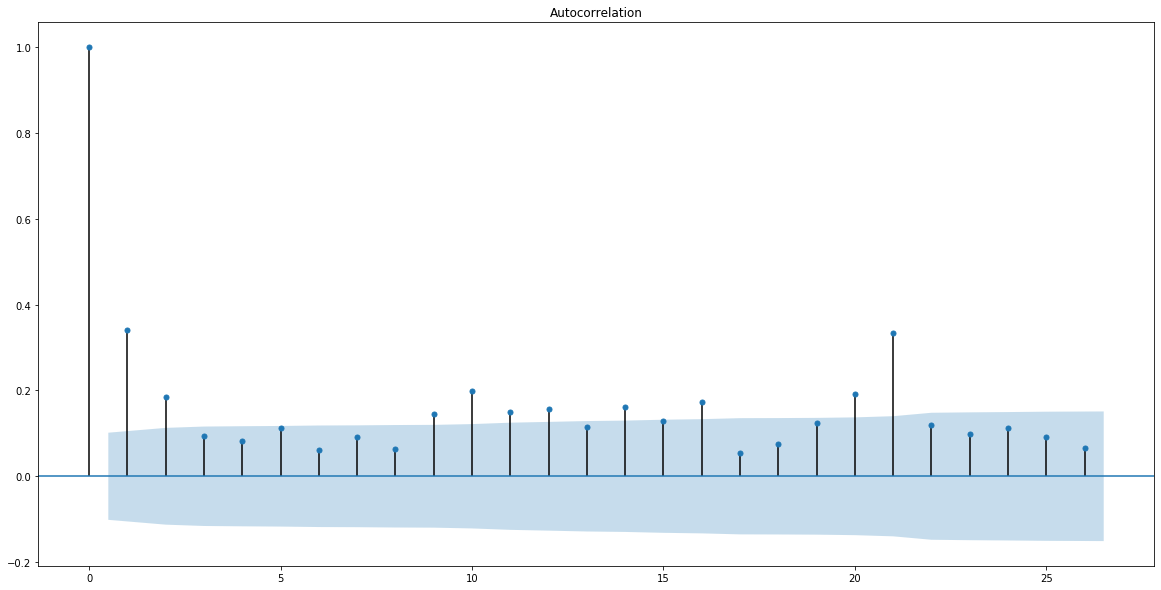

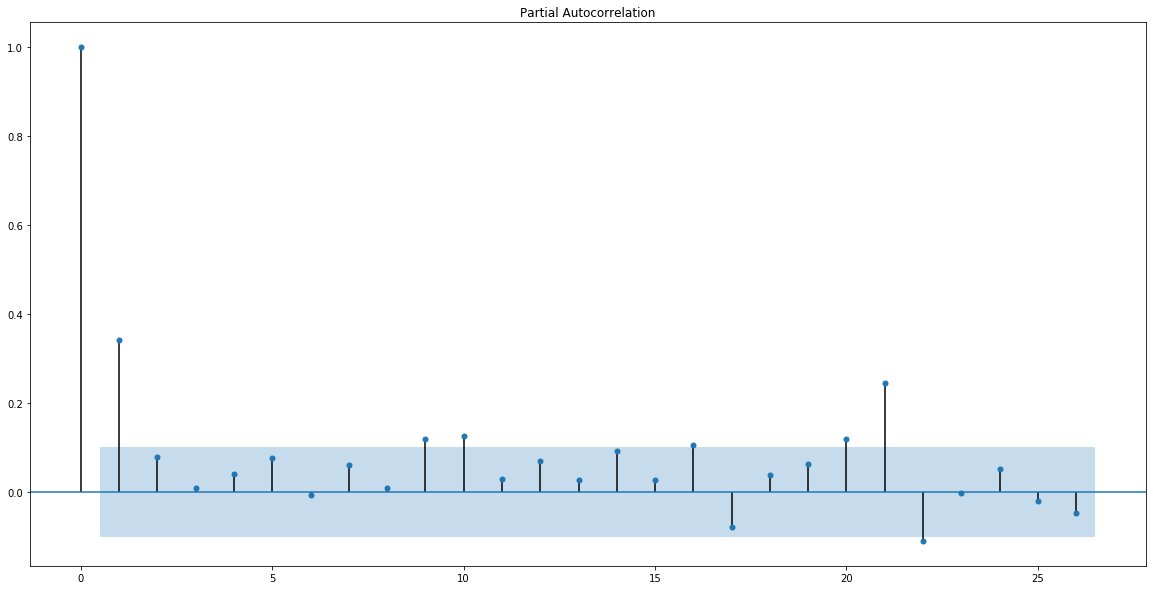

In [15]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(Jacket['sold_count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
   print('\t%s: %.3f' % (key, value))

plot_acf(Jacket['sold_count'])
plot_pacf(Jacket['sold_count']);
plt.show()

<font size = 5>
<font color = orange>
AR, MA, ARMA and ARIMA Modelling    

<br>  

<font size = 4>
    
Autoregressive Modelling

<font color = black>    

Shifting the series n steps back, we get a feature column where the current value of time series is aligned with its value at time t−n. In our case n is the number of days since we have daily sales data of each product.

If we make a 1 lag shift and train a model on that feature, the model will be able to forecast 1 step ahead from having observed the current state of the series. Increasing the lag, say, up to 6, will allow the model to make predictions 6 steps ahead; however it will use data observed 6 steps back. If something fundamentally changes the series during that unobserved period, the model will not catch these changes and will return forecasts with a large error. Therefore, during the initial lag selection, one has to find a balance between the optimal prediction quality and the length of the forecasting horizon.    

There's a couple of very useful functions to determine Autocorrelation and Partial Autocorrelation.
    
A common rule of thumb is to consider PACF for the AR degree - essentially find the N first lags that are above the confidence interval. Having this in mind, we will now assume AR(2) for the "Jacket" dataset.

An important note is that this rule is just an indication for the starting point. It is quite common that you need to try different values.   
    
    
Now let's move on to the MA component of our model. Again, the ACF result can help you guide yourself. However, the model now will be more sensitive to estimate. You should always try with the lowest values, because it's possible that the model is not possible to estimate (invert) anyway...

What people do is select the degree by the number of first ACF correlations that are clearly above the confidence interval.    
    
<font size = 4>
    
<font color = orange>      
    
Moving Average Modelling

<font color = black>     
    
For the MA component of our model, we can checl the ACF result that can help us guide ourselves. After creating the AR component, the model will be more sensitive to estimate. We should always try with the lowest values, because it's possible that the model is not possible to estimate (invert) anyway...

What people do is select the degree by the number of first ACF correlations that are clearly above the confidence interval. In our case, we can select MA component as 3 which will give us ARMA(2,3) model.
    
<font color = orange>      
    
ARIMA Modelling

<font color = black>  
    
We finally arrived to the last model: the full ARIMA model, which has all components, of Auto Regressive (AR), Integration (I) and Moving Average (MA).    
    
A crucial question now relates to the I component. Is the data already stationary? Do we need to work on it? The first thing to do is run the Augmented Dickey-Fuller (ADF) test to see if data is stationary or not. From ADF test, it's clear that the data is stationary enough not to need the I part. We can observe p-value which significantly lower than critical values such 1%, 5% and 10%. In that case, we should keep our model as (2, 0, 3).
    
<font color = orange>      
    
Small Notes Regarding Data Transformation

<font color = black>      
 
* When sales data is not stationary because its mean and variance are not constant, it is necessary to apply some data transformation processes.
* Since the data seems it has trend, we need to use regular or seasonal differencing or both of them because variance increases as mean increases which suggests a multiplicative model. 
* Taking logarithm to convert the multiplicative model to an additive model should be considered if needed to especially stabilize variance.   
* In our cases, regular differencing at order 1 is adequate at which we will see throughout the analysis.

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=677.1659907903859, pvalue=9.021389492350504e-148)

Lets check QQPlot to observe if residuals have normal distribution?


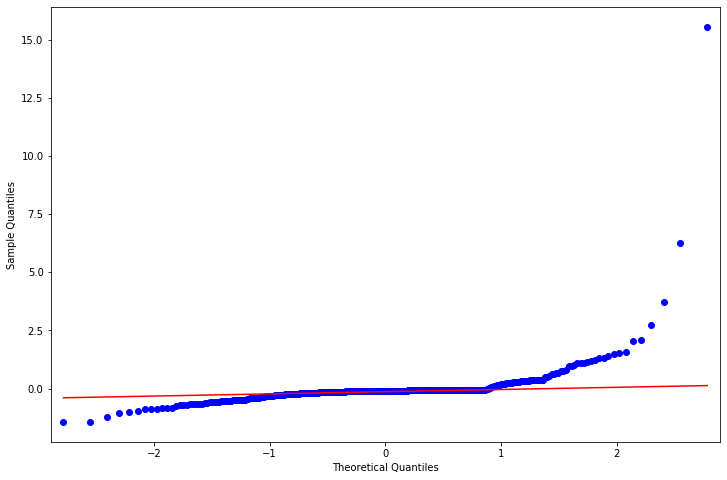

Prediction for one day later is: [0.14729008]
Let's plot predictions


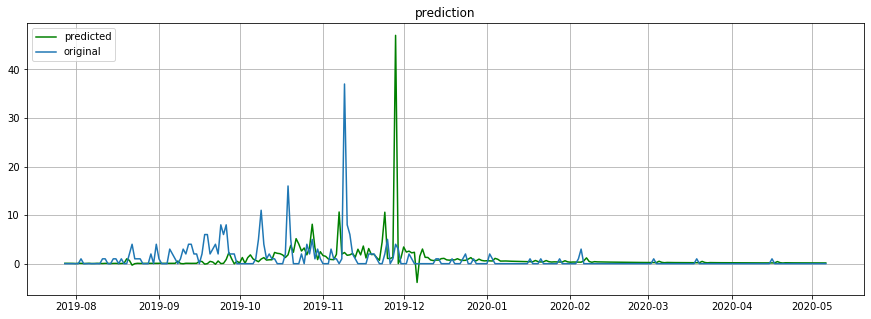

Statistical Evaluation
ARMA(2,3): 
	r^2=-0.912306
	MAE=1.393091
	MAPE=inf
0.14729008305573726


In [16]:
def arma_one_by_one(df, df_attribute, AR_count, MA_count, predict_from='2020-05-06', predict_to='2020-05-07'):
    from statsmodels.tsa.arima_model import ARMA
    from numpy.linalg import LinAlgError
    import statsmodels.api as sm
    from statsmodels.graphics.api import qqplot
    from scipy import stats
    # as a rule of thumb, we should have a threshold for number of observations
    max_value = max(AR_count, MA_count) + 50 # to satisfy number of degress to have ARMA model
    preds=[]
    for l in df[df_attribute].index:
        data=df[df_attribute][df.index<l] # +pd.Timedelta(days=1)
        if data.shape[0] > max_value:
            try:
                arma_model=ARMA(data, order=(AR_count, MA_count)).fit(disp=False)
                preds.append(arma_model.forecast()[0])
            except (ValueError, LinAlgError): 
                pass
        else:
            pass
    #The forecast method gives only point forecasts.        
      
    print('With the latest model: \n')
    resid = arma_model.resid
    print('What is the Normal Distribution test result? \n-',stats.normaltest(resid))
    print('\nLets check QQPlot to observe if residuals have normal distribution?')
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    plt.show()
    
    latest_pred = arma_model.forecast()[0]
    print('Prediction for one day later is: {}'.format(latest_pred))

    
    print("Let's plot predictions")
    y_pred=np.array(preds).T[0]
    limit_one = df[df_attribute].shape[0]
    limit_two = limit_one - y_pred.shape[0]
    plotprediction(df[df_attribute][limit_two:], y_pred)
    plt.show()

    print("Statistical Evaluation")
    print_stats(df[df_attribute][limit_two:], y_pred, 'ARMA({},{})'.format(AR_count,MA_count))
    
    return latest_pred[0]

preds = arma_one_by_one(Jacket, 'sold_count', 2, 3)
print(preds)

Model parameters are:  const               0.774088
ar.L1.sold_count    0.848688
ar.L2.sold_count    0.130477
ma.L1.sold_count   -0.573118
ma.L2.sold_count   -0.234360
ma.L3.sold_count   -0.107994
dtype: float64
AIC is:  1419.2664531284308 
 BIC is:  1445.1461075339687
Durbin Watson Test:  1.9997489812492253
Let's see if residuals are stationary or not. (Mean and variance should seems as constant over time.)


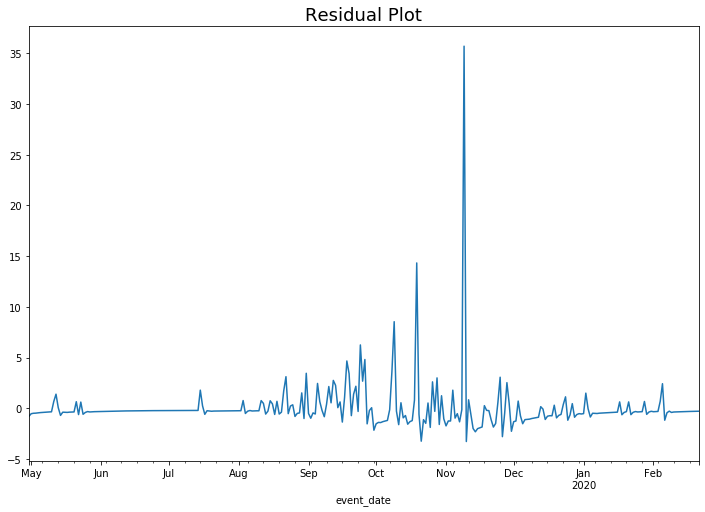

What is the Normal Distribution test result? 
- NormaltestResult(statistic=526.2810233070483, pvalue=5.242371859123741e-115)

Lets check QQPlot to observe if residuals have normal distribution?


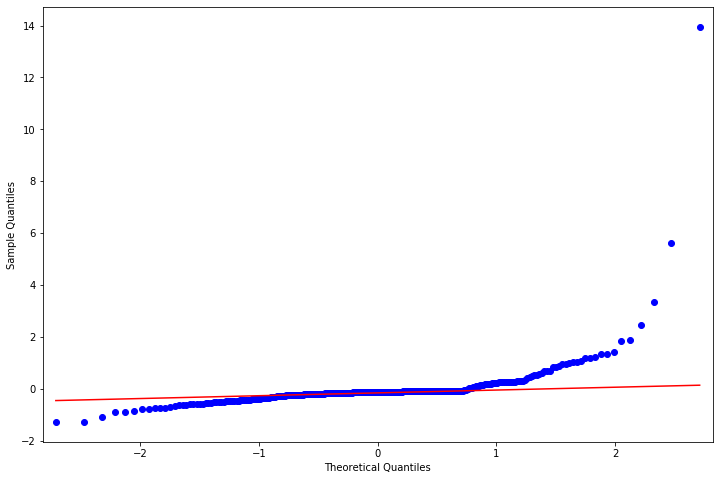

Prediction for one day later is: [0.27099781]

Let's plot predictions with train data


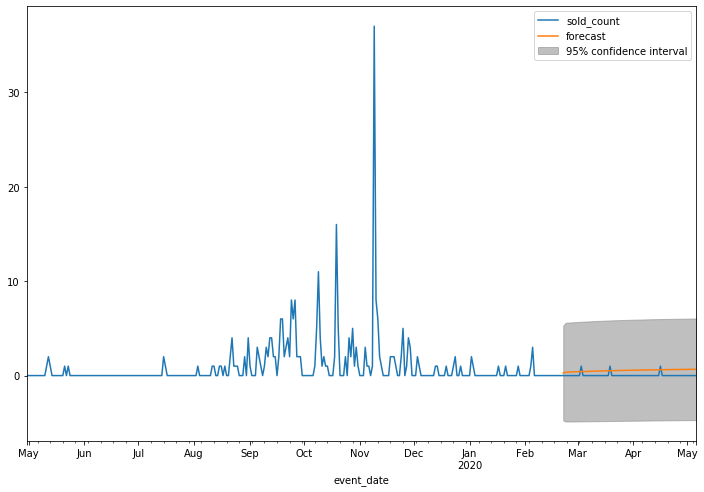

Let's observe plot predictions in a focused window


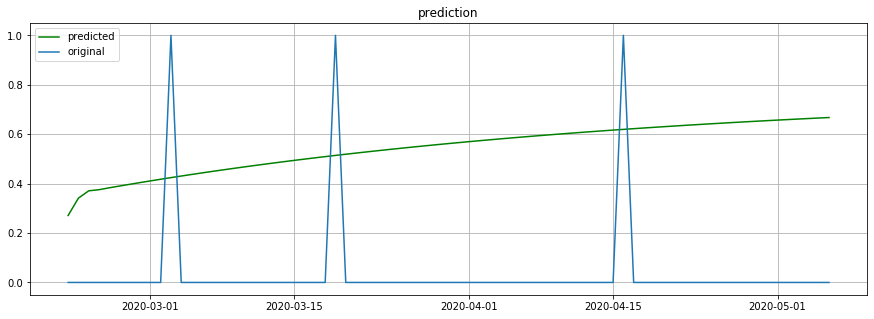

Statistical Evaluation
ARMA(2,3): 
	r^2=-6.875875
	MAE=0.541723
	MAPE=inf
0.2709978133107369


In [17]:
def arma_usual(df, df_attribute, AR_component, MA_component, predict_from = '2020-02-22', predict_to = '2020-05-06'):
    from statsmodels.tsa.arima_model import ARMA
    import statsmodels.api as sm
    from statsmodels.graphics.api import qqplot
    from scipy import stats

    arma_model = sm.tsa.ARMA(df[globals()['{}_train_ix'.format(str(df.name))]][df_attribute], (AR_component,MA_component)).fit(disp=False)
    print('Model parameters are: ',arma_model.params)
    print('AIC is: ', arma_model.aic, '\n BIC is: ', arma_model.bic)
    print('Durbin Watson Test: ', sm.stats.durbin_watson(arma_model.resid.values))
    print("Let's see if residuals are stationary or not. (Mean and variance should seems as constant over time.)")
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_title('Residual Plot', size=18)
    ax = arma_model.resid.plot(ax=ax)
    plt.show()

    resid = arma_model.resid
    print('What is the Normal Distribution test result? \n-',stats.normaltest(resid))
    print('\nLets check QQPlot to observe if residuals have normal distribution?')
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    plt.show()
    
    preds = arma_model.predict(predict_from, predict_to, dynamic=True)
    latest_pred = arma_model.forecast()[0]
    print('Prediction for one day later is: {}\n'.format(latest_pred))
    print("Let's plot predictions with train data")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = df[df_attribute].plot(ax=ax)
    fig = arma_model.plot_predict(predict_from, predict_to, dynamic=True, ax=ax, plot_insample=False)   
    plt.show()
    
    print("Let's observe plot predictions in a focused window")
    plotprediction(df[globals()['{}_test_ix'.format(str(df.name))]][df_attribute], preds)
    plt.show()
    
    print("Statistical Evaluation")
    print_stats(df[globals()['{}_test_ix'.format(str(df.name))]][df_attribute], preds, 'ARMA({},{})'.format(AR_component,MA_component))
    return latest_pred[0]

preds = arma_usual(Jacket, 'sold_count', 2, 3)
print(preds)

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=677.1659907903859, pvalue=9.021389492350504e-148)

Lets check QQPlot to observe if residuals have normal distribution?


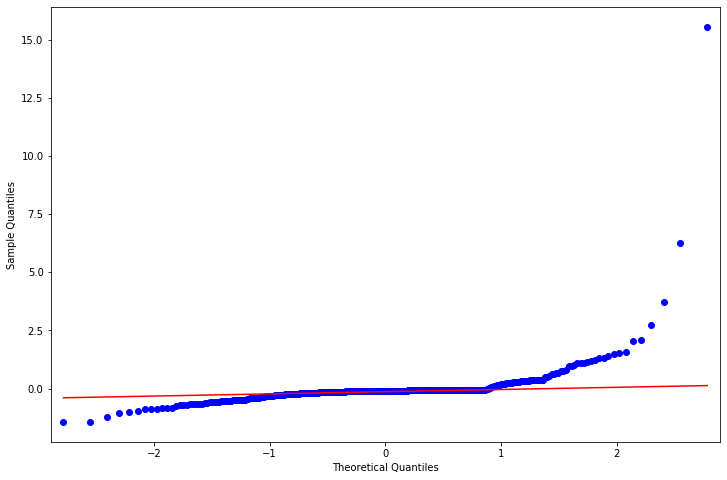

Prediction for one day later is: [0.14729008]
Let's plot predictions


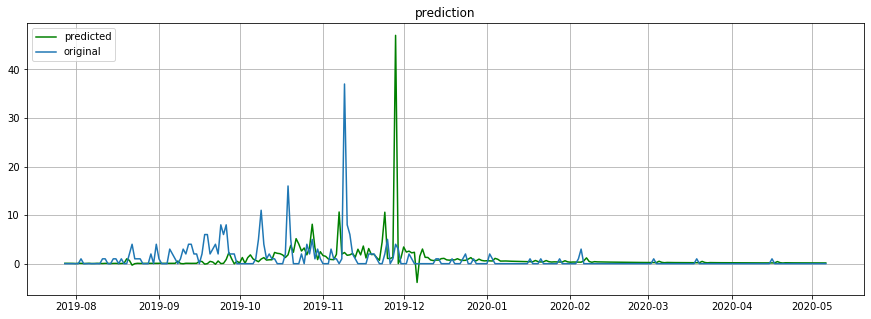

Statistical Evaluation
ARIMA(2,0,3): 
	r^2=-0.912306
	MAE=1.393091
	MAPE=inf
0.14729008305573726


In [18]:
def arima_one_by_one(df, df_attribute, AR_count, Int_count, MA_count, predict_from='2020-05-06', predict_to='2020-05-07'):
    from statsmodels.tsa.arima_model import ARIMA
    from numpy.linalg import LinAlgError
    import statsmodels.api as sm
    from statsmodels.graphics.api import qqplot
    from scipy import stats
    
    # as a rule of thumb, we should have a threshold for number of observations
    max_value = max(AR_count, MA_count) + 50 # to satisfy number of degress to have ARMA model
    preds=[]
    for l in df[df_attribute].index:
        data=df[df_attribute][df.index<l] # +pd.Timedelta(days=1)
        if data.shape[0] > max_value:
            try:
                arma_model=ARIMA(data, order=(AR_count, Int_count, MA_count)).fit(disp=False)
                preds.append(arma_model.forecast()[0])
            except (ValueError, LinAlgError): 
                pass
        else:
            pass

    #The forecast method gives only point forecasts.        
      
    print('With the latest model: \n')
    resid = arma_model.resid
    print('What is the Normal Distribution test result? \n-',stats.normaltest(resid))
    print('\nLets check QQPlot to observe if residuals have normal distribution?')
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    plt.show()
    
    latest_pred = arma_model.forecast()[0]
    print('Prediction for one day later is: {}'.format(latest_pred))

    
    print("Let's plot predictions")
    y_pred=np.array(preds).T[0]
    limit_one = df[df_attribute].shape[0]
    limit_two = limit_one - y_pred.shape[0]
    plotprediction(df[df_attribute][limit_two:], y_pred)
    plt.show()

    print("Statistical Evaluation")
    print_stats(df[df_attribute][limit_two:], y_pred, 'ARIMA({},{},{})'.format(AR_count,Int_count,MA_count))
    
    return latest_pred[0]

preds = arima_one_by_one(Jacket, 'sold_count', 2, 0, 3)
print(preds)

Model parameters are:  const               0.774088
ar.L1.sold_count    0.848688
ar.L2.sold_count    0.130477
ma.L1.sold_count   -0.573118
ma.L2.sold_count   -0.234360
ma.L3.sold_count   -0.107994
dtype: float64
AIC is:  1419.2664531284308 
 BIC is:  1445.1461075339687
Durbin Watson Test:  1.9997489812492253
Let's see if residuals are stationary or not. (Mean and variance should seems as constant over time.)


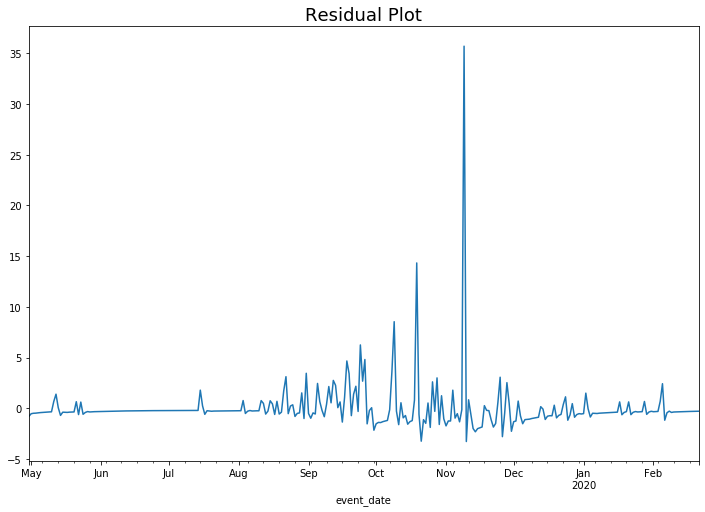

What is the Normal Distribution test result? 
- NormaltestResult(statistic=526.2810233070483, pvalue=5.242371859123741e-115)

Lets check QQPlot to observe if residuals have normal distribution?


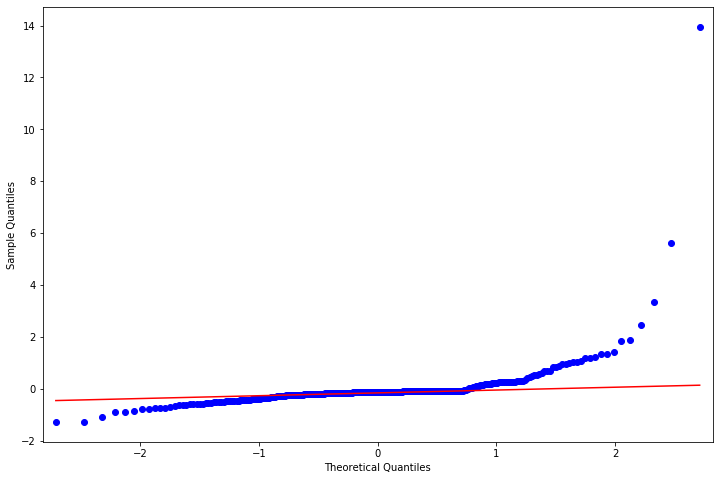

Prediction for one day later is: [0.27099781]

Let's plot predictions with train data


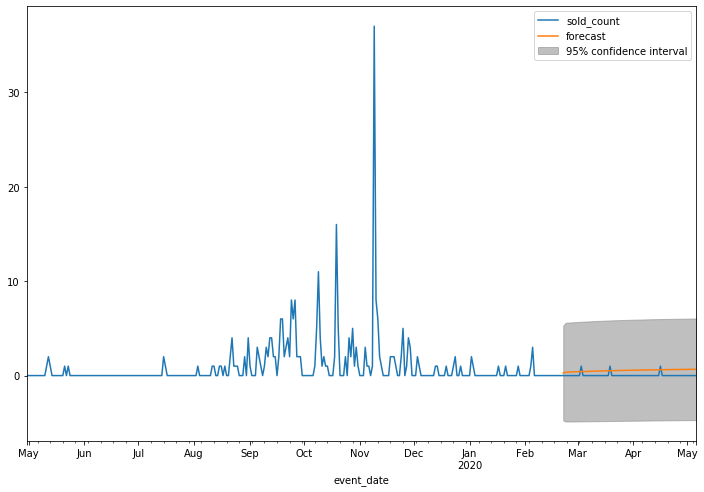

Let's observe plot predictions in a focused window


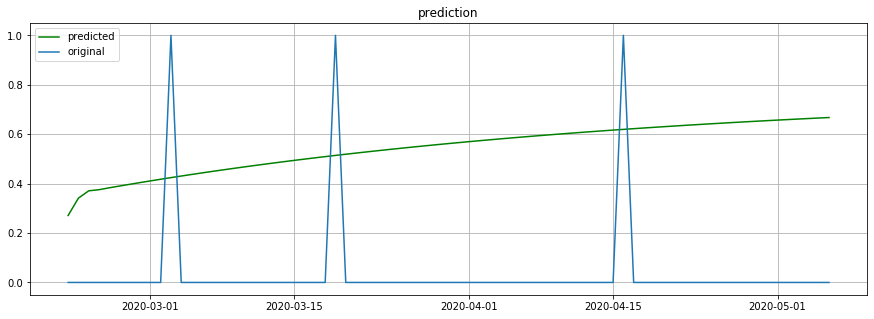

Statistical Evaluation
ARIMA(2,0,3): 
	r^2=-6.875875
	MAE=0.541723
	MAPE=inf
0.2709978133107369


In [19]:
def arima_usual(df, df_attribute, AR_component, INT_component, MA_component, predict_from = '2020-02-22', predict_to = '2020-05-06'):
    import statsmodels.api as sm
    from statsmodels.graphics.api import qqplot
    from scipy import stats
    from statsmodels.tsa.arima_model import ARIMA

    arma_model = sm.tsa.ARIMA(df[globals()['{}_train_ix'.format(str(df.name))]][df_attribute], (AR_component, INT_component, MA_component)).fit(disp=False)
    print('Model parameters are: ',arma_model.params)
    print('AIC is: ', arma_model.aic, '\n BIC is: ', arma_model.bic)
    print('Durbin Watson Test: ', sm.stats.durbin_watson(arma_model.resid.values))
    print("Let's see if residuals are stationary or not. (Mean and variance should seems as constant over time.)")
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    ax.set_title('Residual Plot', size=18)
    ax = arma_model.resid.plot(ax=ax)
    plt.show()

    resid = arma_model.resid
    print('What is the Normal Distribution test result? \n-',stats.normaltest(resid))
    print('\nLets check QQPlot to observe if residuals have normal distribution?')
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111)
    fig = qqplot(resid, line='q', ax=ax, fit=True)
    plt.show()
    
    preds = arma_model.predict(predict_from, predict_to, dynamic=True)
    latest_pred = arma_model.forecast()[0]
    
    print('Prediction for one day later is: {}\n'.format(latest_pred))
    print("Let's plot predictions with train data")
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = df[df_attribute].plot(ax=ax)
    fig = arma_model.plot_predict(predict_from, predict_to, dynamic=True, ax=ax, plot_insample=False)   
    plt.show()
    
    print("Let's observe plot predictions in a focused window")
    plotprediction(df[globals()['{}_test_ix'.format(str(df.name))]][df_attribute], preds)
    plt.show()
    
    print("Statistical Evaluation")
    print_stats(df[globals()['{}_test_ix'.format(str(df.name))]][df_attribute], preds, 'ARIMA({},{},{})'.format(AR_component,INT_component,MA_component))
    return latest_pred[0]

preds = arima_usual(Jacket, 'sold_count', 2, 0, 3)
print(preds)

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1421.148, BIC=1450.698, Time=0.334 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1537.049, BIC=1544.437, Time=0.014 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1494.619, BIC=1509.394, Time=0.101 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1428.989, BIC=1443.764, Time=0.149 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1535.049, BIC=1538.743, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1419.140, BIC=1444.996, Time=0.256 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=1417.553, BIC=1439.715, Time=0.120 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1419.126, BIC=1444.982, Time=0.245 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=1420.726, BIC=1439.195, Time=0.102 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=1416.008, BIC=1434.477, Time=0.120 seconds
Fit ARIMA(2,1,1)x(1,0,0,12

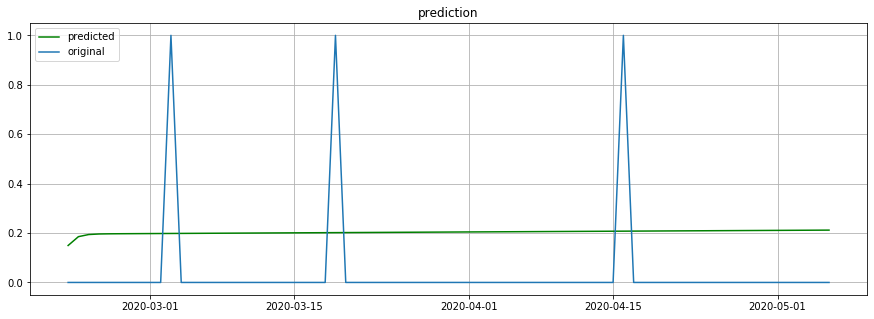

In [20]:
#Check the source below for auto arima package:
#http://alkaline-ml.com/pmdarima/1.6.1/auto_examples/example_simple_fit.html#sphx-glr-auto-examples-example-simple-fit-py
def apply_auto_arima(df, df_attribute):
    from pandas.util._decorators import Appender
    import pmdarima as pm
    from pmdarima import model_selection
    # Load the data and split it into separate pieces

    # Fit a simple auto_arima model
    train = df[globals()['{}_train_ix'.format(str(df.name))]][df_attribute]
    test = df[globals()['{}_test_ix'.format(str(df.name))]][df_attribute]
    arima = pm.auto_arima(train, error_action='ignore', trace=True,
                          suppress_warnings=True, maxiter=10,
                          seasonal=True, m=12)

    pred = arima.predict(n_periods=test.shape[0])
    print("\nForecasts:")
    print(pred)
    # Plot actual test vs. forecasts:
    print_stats(test, pred, str('auto arima'))
    plotprediction(test, pred)
    print(arima.summary())
    
apply_auto_arima(Jacket, 'sold_count')

In [21]:
#Check the source below for auto arima package:
#http://alkaline-ml.com/pmdarima/1.6.1/auto_examples/example_simple_fit.html#sphx-glr-auto-examples-example-simple-fit-py
def apply_auto_arima_all_data(df, df_attribute):
    from pandas.util._decorators import Appender
    import pmdarima as pm
    from pmdarima import model_selection
    # Fit a simple auto_arima model
    train = df[df_attribute]
    arima = pm.auto_arima(train, error_action='ignore', trace=True, suppress_warnings=True, maxiter=10, seasonal=True, m=12)
    print(arima.summary())
apply_auto_arima_all_data(Jacket, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1692.377, BIC=1723.729, Time=0.372 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1841.158, BIC=1848.996, Time=0.084 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1786.886, BIC=1802.562, Time=0.108 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1704.115, BIC=1719.791, Time=0.190 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1839.158, BIC=1843.077, Time=0.016 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1690.362, BIC=1717.794, Time=0.287 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=1688.901, BIC=1712.415, Time=0.142 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1690.387, BIC=1717.819, Time=0.275 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=1690.763, BIC=1710.358, Time=0.119 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=1688.389, BIC=1707.983, Time=0.131 seconds
Fit ARIMA(2,1,1)x(1,0,0,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=663.1074698426047, pvalue=1.0186910000558224e-144)

Lets check QQPlot to observe if residuals have normal distribution?


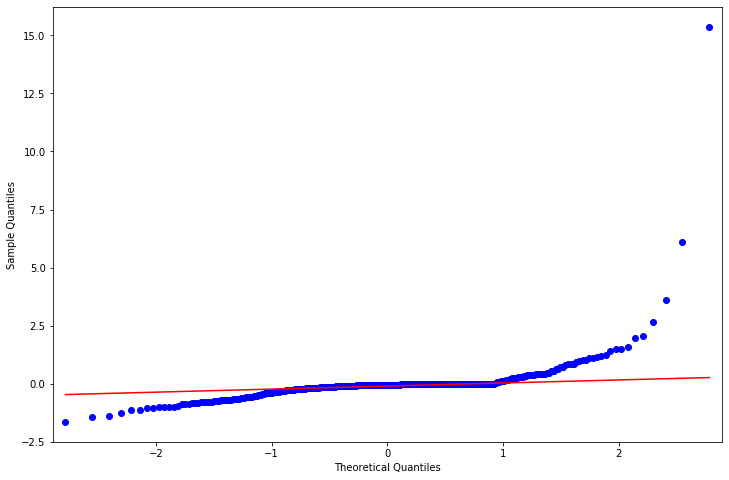

Prediction for one day later is: [0.01788432]
Let's plot predictions


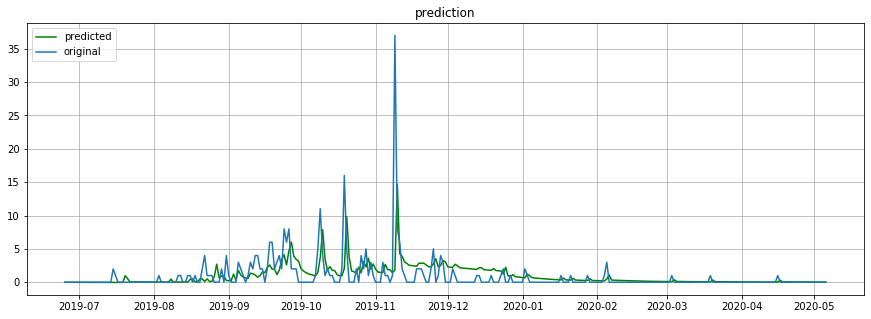

Statistical Evaluation
ARIMA(1,1,1): 
	r^2=0.091651
	MAE=1.027228
	MAPE=inf
0.01788432393699345


In [22]:
preds = arima_one_by_one(Jacket, 'sold_count', 1, 1, 1)
print(preds)

As you can see from above, we have arma_usual(), arima_usual(), arma_one_by_one(), arima_one_by_one() and apply_auto_arima() functions. arma_usual() and arima_usual() functions, takes input data and train arma or arima model with 80% of all data and then test the model wiht 20% of data. These two functions prints model parameters, AIC, BIC, Durbin Watson Test results. Then plots residual plot, qqplot to see if residuals distribution is normal distribution. For residuals p value and normal distribution score is reported as well. Then, predictions with both train and test data is plotted. To see test data and predictions better in a focused window, predictions and test data are plotted again. Statistical evaluation such as, R^2, mean absolute error and mean absolute percentage error is reported. Finally, next day preiction returned. arma_one_by_one() and arima_one_by_one() functions has different logic. Before making each prediction, we re-estimate the model with **ALL** previous data
We will have N models estimated, although we only keep the last one. For example, we will predict 51th day, with 50 days of observations. In that sense, plots are making more sense and prediction for each data is better tailored. When we train a model with 80% of data and predict rest of the days with this 80% of data may lead to skip observation. Except plotting train and test data together and residual plot, all of others produced like in arma_usual and arima_usual functions. apply_auto_arima() function takes 80% of data and train ARIMA models and tries to find minimized AIC model and returns model trials and summaries. Then prediction is created according to best model with 80% of data and 20% of test data is predicted and plotted with prediction and test data. apply_auto_arima_all_data() function trains auto_arima with all data to again find best model. Since there isn't test data left, it just returns arima summary and model trials.

Explanation for _'Jacket'_ :

As we have mentioned before, to find the best fit model after viewing acf and pacf graphs we need to look at other values for AR and MA components. For Jacket product, we checked acf and pacf graphs and with ARMA(2,3) and ARIMA(2,0,3) models (which are the same since ARIMA's integration part is zero), yielded ~1.393 mean absolute error. Since there were zero values in the sales, mean absolute percentage error is infinite. Then we applied apply_auto_arima() and apply_auto_arima_all_data functions to get best model (Best model is decided when AIC is minimized). ARIMA(1,1,1) model yielded ~1.027 which smaller than previous model. We can conclude that, for other products it is enough to apply auto arima and get best model. Then with the best model, we can check the one by one predictions with arima_one_by_one() function. For the other products, we will discuss stationarity for each model and if needed we will apply differencing or logarithm transformation methods.

In [26]:
from statsmodels.tsa.stattools import adfuller

def stationarity_interpret(ds):
    print('Stationarity Analysis for: {}'.format(ds.name))
    result = adfuller(ds['sold_count'])
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    return result[1]

def apply_log(ds):
    emp = pd.DataFrame()
    emp.name = ds.nam
    y = ds.sold_count
    y += 1 # in case of '0' values
    y = np.log10(y)
    emp['sold_count'] = y
    
    return emp

def apply_diff(ds):
    from statsmodels.tsa.statespace import tools
    y = tools.diff(ds['sold_count'], 1)
    emp = pd.DataFrame()
    emp.name = ds.name
    emp['sold_count'] = y
    return emp

Plot and Analysis for: Facial_Cleanser


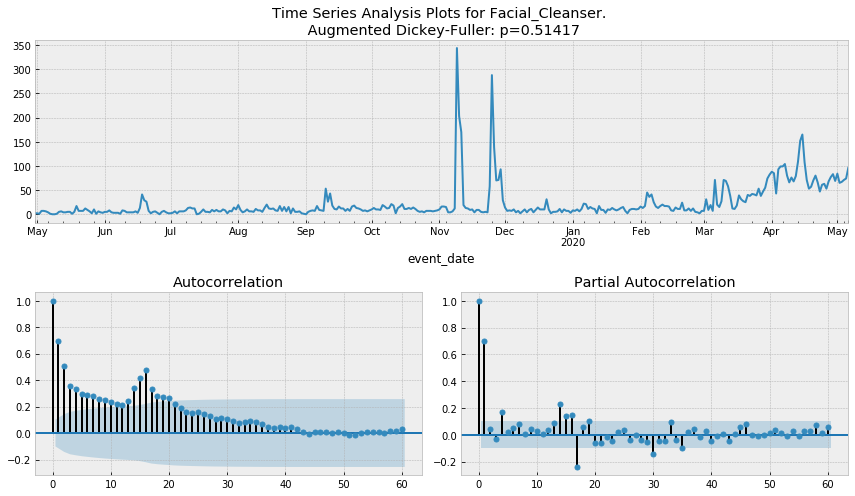

Facial_Cleanser need Transformation
Plot and Analysis for: Vacuum_Cleaner


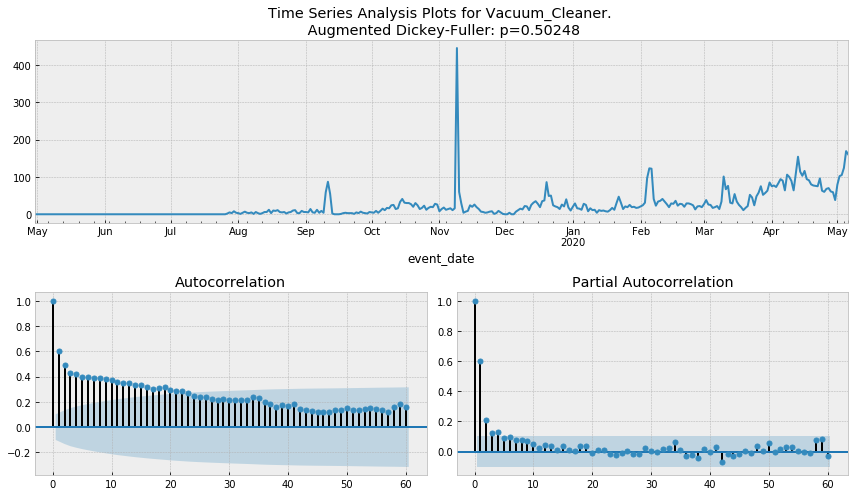

Vacuum_Cleaner need Transformation
Plot and Analysis for: Phone_Bluetooth_Headset


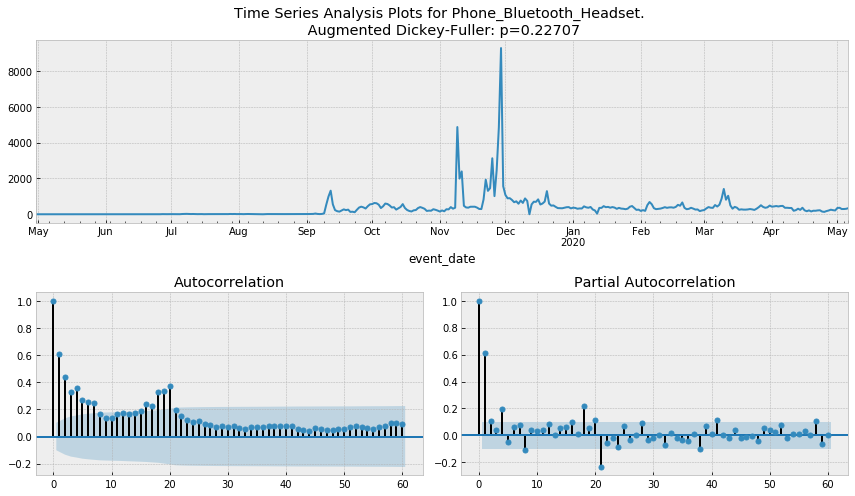

Phone_Bluetooth_Headset need Transformation
Plot and Analysis for: Bikini_Top


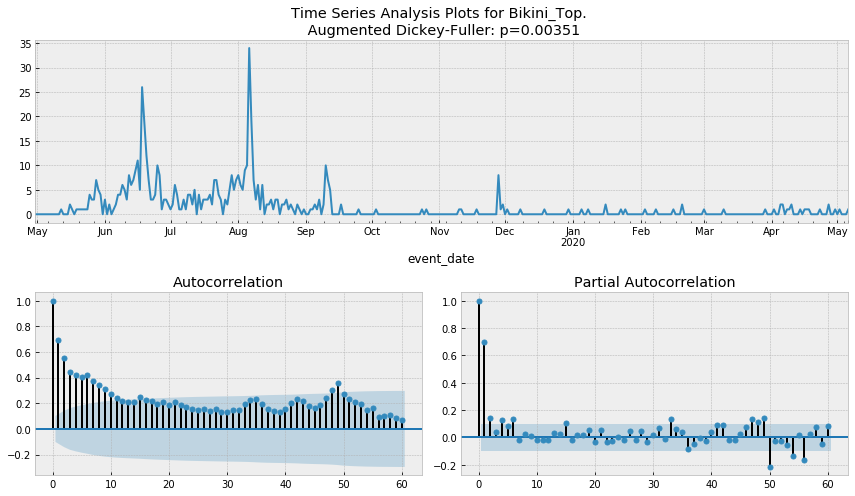

Bikini_Top DOESNT need Transformation
Plot and Analysis for: Wet_Wipes_Towel


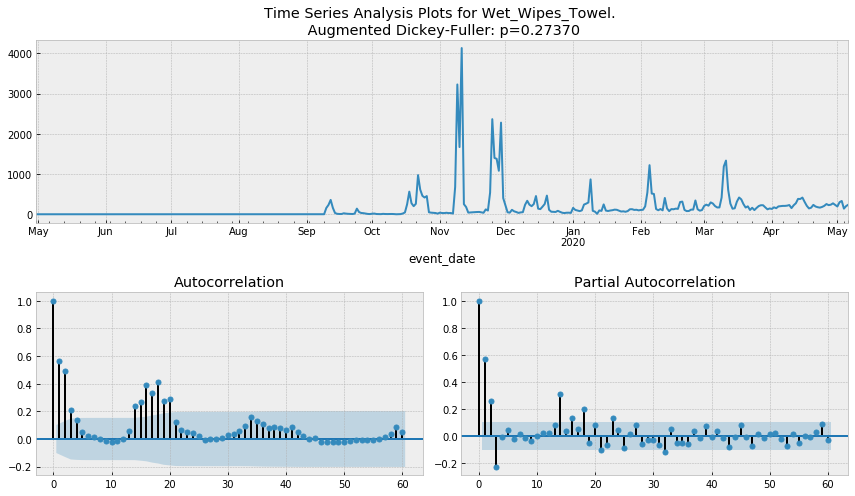

Wet_Wipes_Towel need Transformation
Plot and Analysis for: Jacket


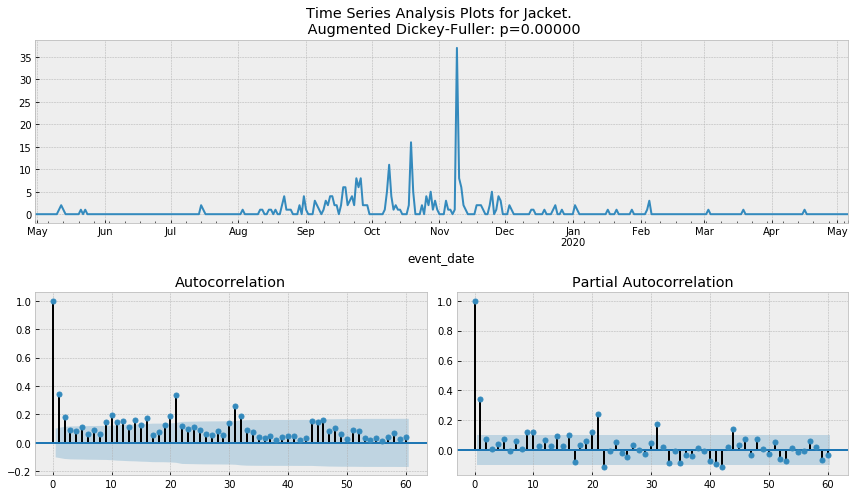

Jacket DOESNT need Transformation
Plot and Analysis for: Rechargeable_Toothbrush


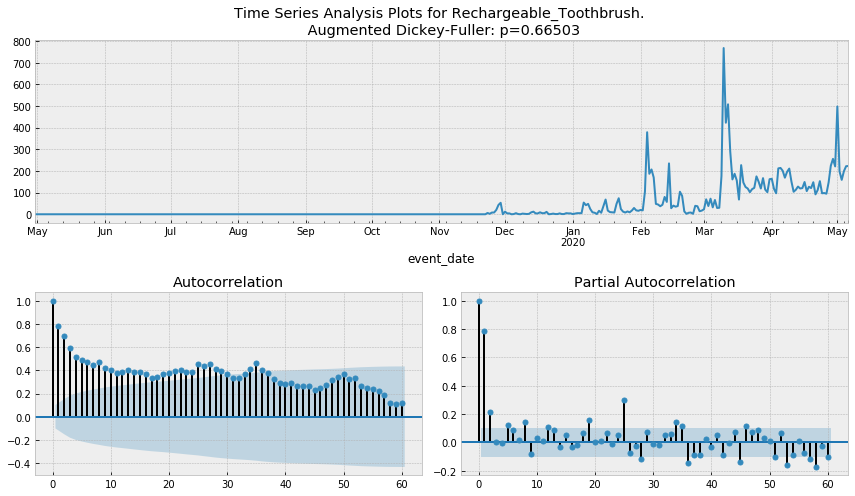

Rechargeable_Toothbrush need Transformation
Plot and Analysis for: Tights


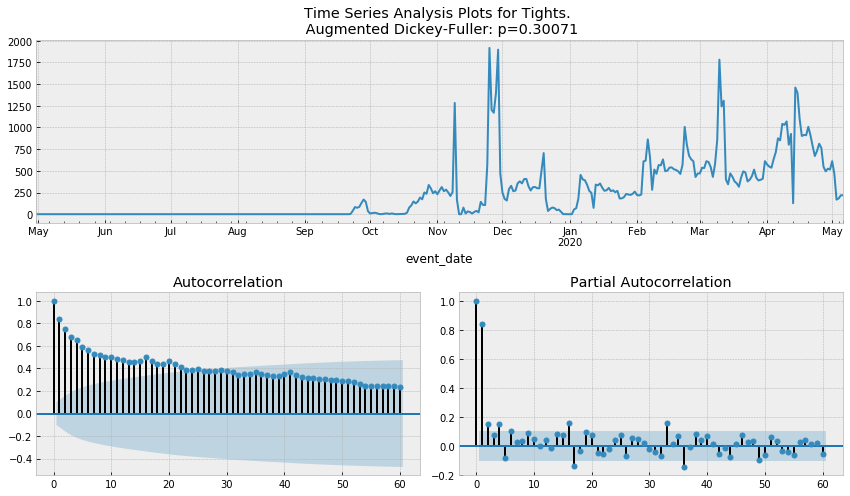

Tights need Transformation


In [27]:
# Another test which is Dickey-Fuller test is applied to understand if data is stationary or not.
# https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python

second_test_needy_ones = []
def plot_and_test(y, df_name, lags=None, figsize=(12, 7), style='bmh'):
    import statsmodels.tsa.api as smt
    import statsmodels as sm
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots for {}. \n Augmented Dickey-Fuller: p={:.5f}'.format(df_name,p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()
    return p_value

dickey_doesnt_need = []
for ds in data_series:
    print('Plot and Analysis for: {}'.format(ds.name))
    p_value = plot_and_test(ds.sold_count, ds.name, lags=60)
    plt.show()
    if p_value < 0.01:
        print('{} DOESNT need Transformation'.format(ds.name))        
        dickey_doesnt_need.append(ds.name)
    else:
        print('{} need Transformation'.format(ds.name))

In [28]:
print(dickey_doesnt_need) # As we have seen before, Jacket doesn't need differencing but best model of Jacket has integration part.

Dickey ['Bikini_Top', 'Jacket']


In [30]:
transform_needed = [i for i in data_series if i.name not in dickey_doesnt_need]
for i in transform_needed:
    print(i.name)

Facial_Cleanser
Vacuum_Cleaner
Phone_Bluetooth_Headset
Wet_Wipes_Towel
Rechargeable_Toothbrush
Tights


Our tests shows that, products bikini top and jacket doesn't need transformation since they are already stationary. Let's apply difference method to other datasets and apply same methods to test their stationarity.

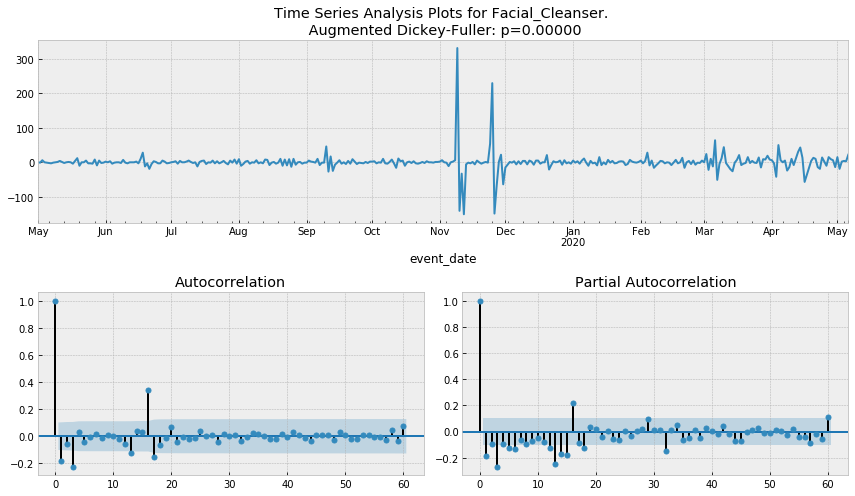

Facial_Cleanser DOESNT need Transformation


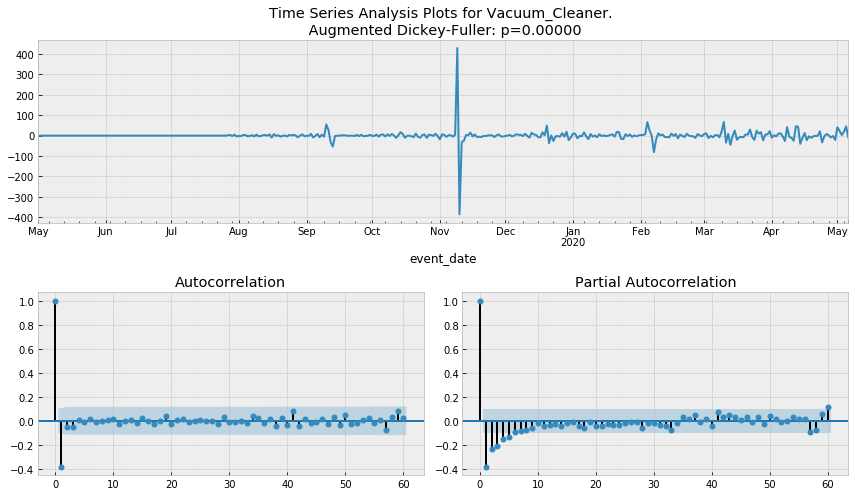

Vacuum_Cleaner DOESNT need Transformation


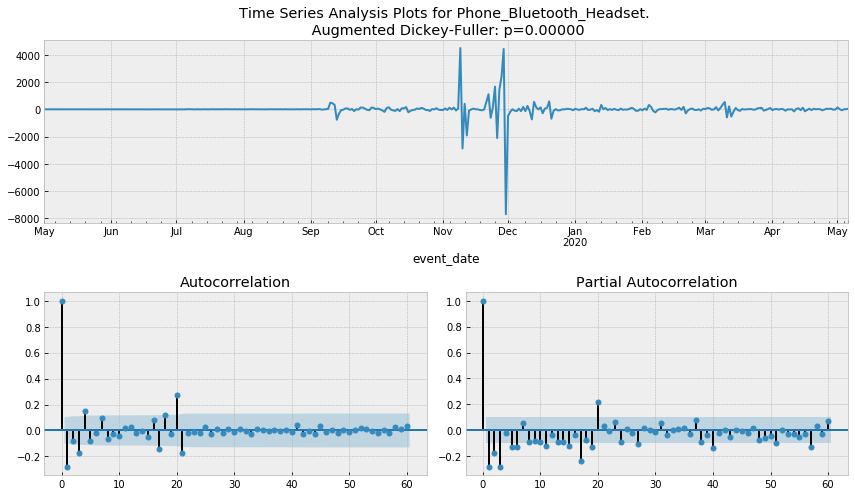

Phone_Bluetooth_Headset DOESNT need Transformation


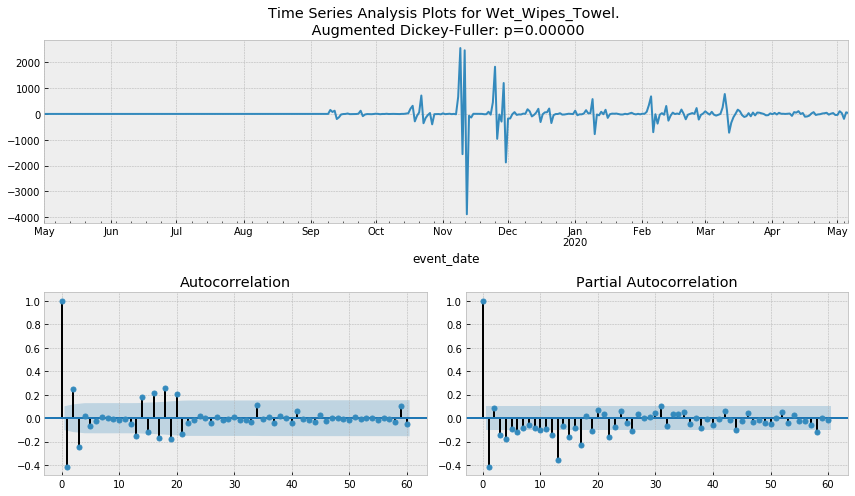

Wet_Wipes_Towel DOESNT need Transformation


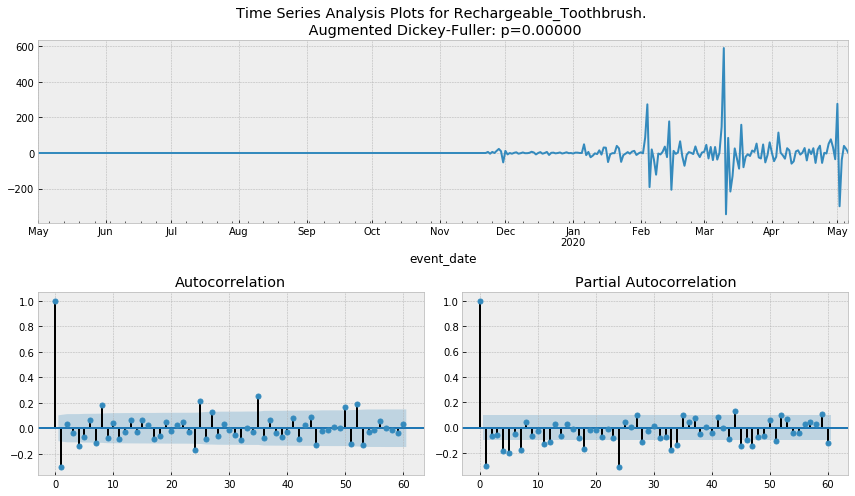

Rechargeable_Toothbrush DOESNT need Transformation


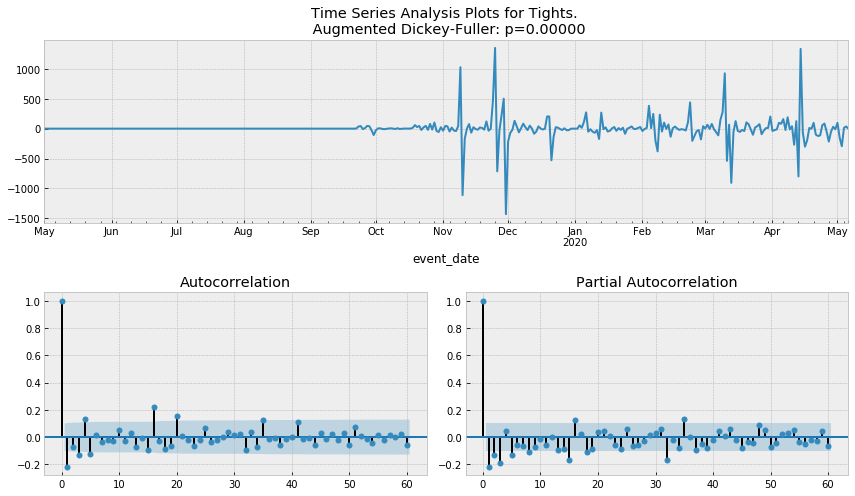

Tights DOESNT need Transformation


In [31]:
second_dickey_doesnt_need = []
for ds in transform_needed:
    diffed_data = apply_diff(globals()[ds.name])
    p_value = plot_and_test(diffed_data.sold_count, diffed_data.name, lags=60)
    plt.show()
    if p_value < 0.01:
        print('{} DOESNT need Transformation'.format(ds.name))        
        second_dickey_doesnt_need.append(ds.name)
    else:
        print('{} need Transformation'.format(ds.name))

After applying regular differencing at order 1, all of the product sales are stationary now.

In [33]:
second_dickey_doesnt_need

['Facial_Cleanser',
 'Vacuum_Cleaner',
 'Phone_Bluetooth_Headset',
 'Wet_Wipes_Towel',
 'Rechargeable_Toothbrush',
 'Tights']

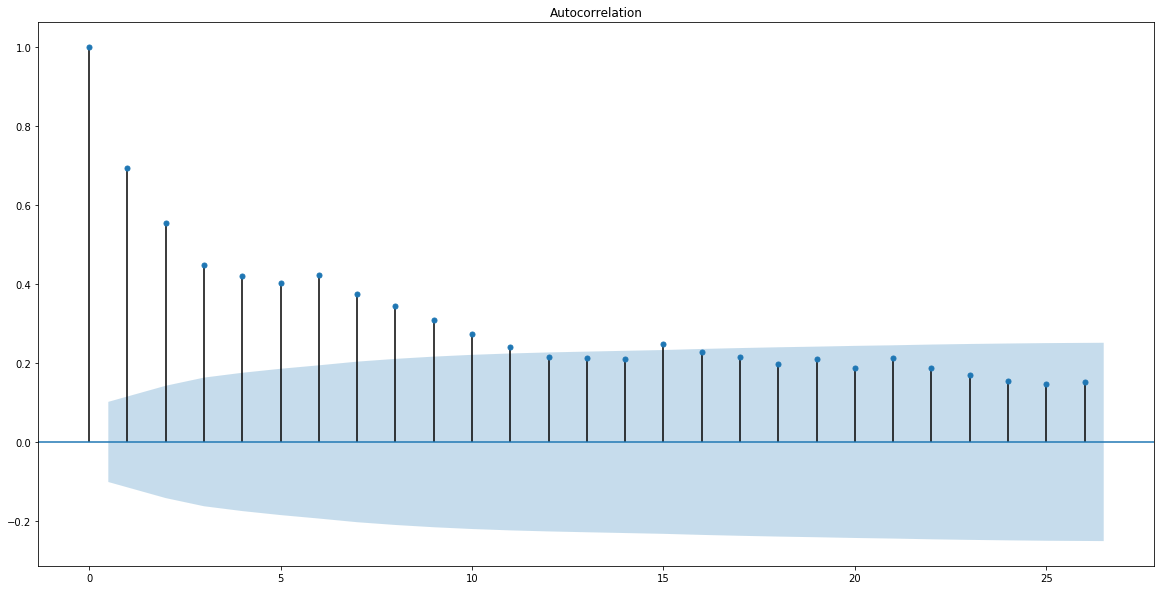

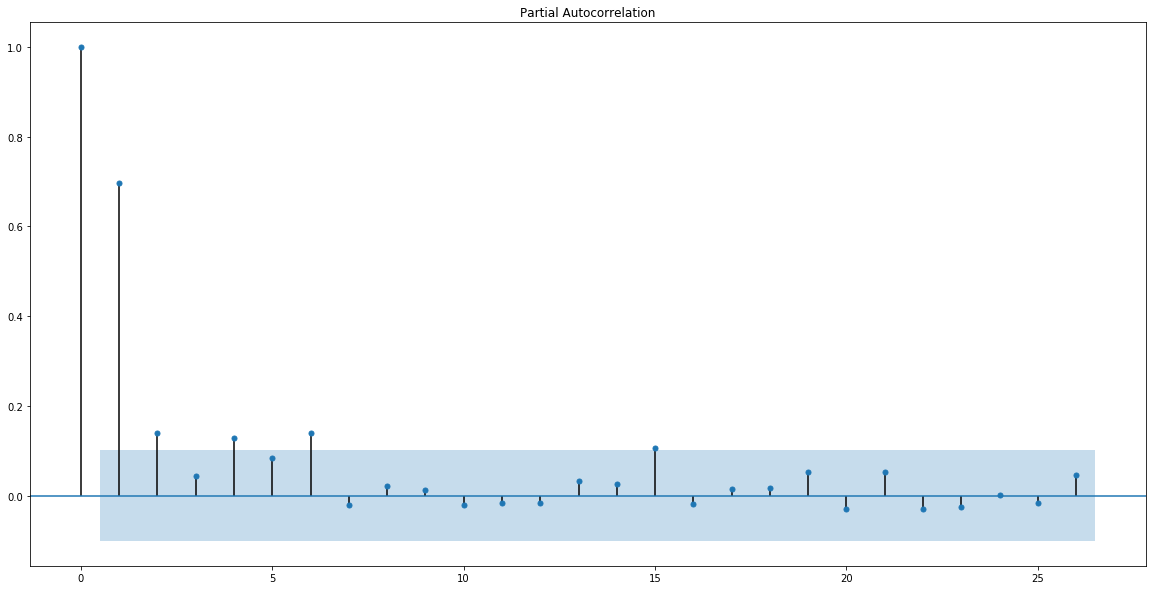

In [34]:
def plot_acf_pacf(df):
    from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
    plot_acf(df['sold_count'])
    plot_pacf(df['sold_count'])

plot_acf_pacf(Bikini_Top)

Like exactly in Jacket example, we can check acf and pacf plots, then apply arma and arima models to find best model. But since we have auto arima function, from now on, I will directly train all data with auto arima function, report best model, then print best prediction with arima_one_by_one() function. Then, I will create a dataframe for my predictions.

Small note: If the best model which is offered by auto arima function has integration part, we don't  need to apply transformation before applying arma or any other model.

In [35]:
apply_auto_arima_all_data(Bikini_Top, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1705.154, BIC=1736.505, Time=0.234 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1770.040, BIC=1777.877, Time=0.013 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1745.273, BIC=1760.948, Time=0.092 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1728.152, BIC=1743.827, Time=0.133 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1768.040, BIC=1771.959, Time=0.012 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1702.962, BIC=1730.394, Time=0.250 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=1701.711, BIC=1725.224, Time=0.140 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1702.994, BIC=1730.427, Time=0.263 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=1701.672, BIC=1721.267, Time=0.113 seconds
Fit ARIMA(1,1,2)x(1,0,0,12) [intercept=True]; AIC=1702.801, BIC=1726.314, Time=0.206 seconds
Fit ARIMA(1,1,2)x(0,0,1,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=459.6525096596463, pvalue=1.5407271334693718e-100)

Lets check QQPlot to observe if residuals have normal distribution?


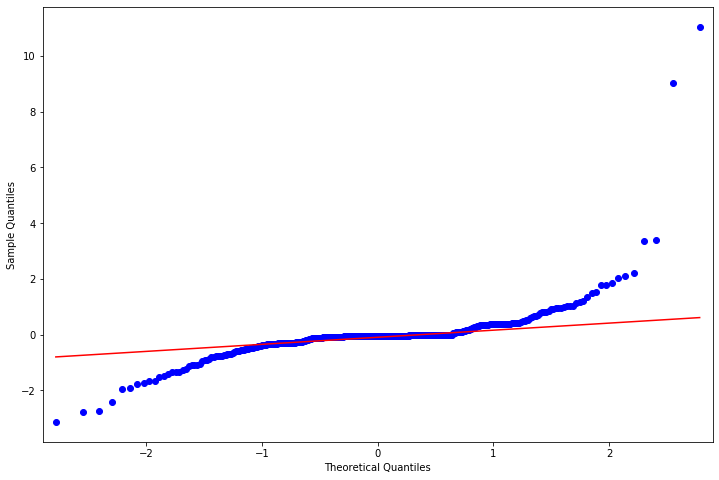

Prediction for one day later is: [0.15227839]
Let's plot predictions


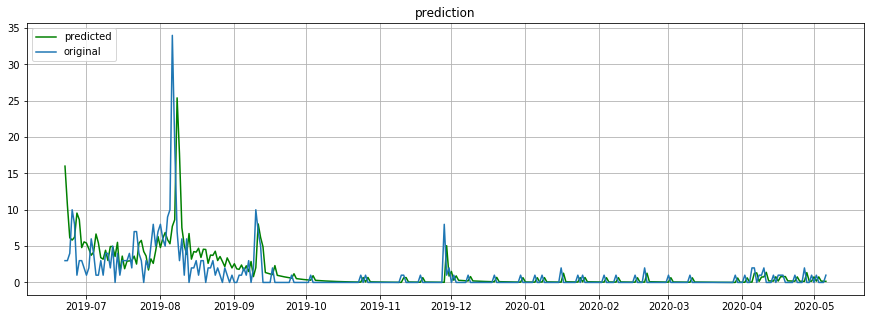

Statistical Evaluation
ARIMA(1,1,1): 
	r^2=0.075783
	MAE=1.164885
	MAPE=inf


{'Bikini_Top': [0]}

In [36]:
pred = arima_one_by_one(Bikini_Top, 'sold_count', 1,1,1)
result_dict = {}
result_dict['Bikini_Top'] = [int(round(pred))]
result_dict

In [37]:
apply_auto_arima_all_data(Jacket, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=1692.377, BIC=1723.729, Time=0.276 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=1841.158, BIC=1848.996, Time=0.014 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=1786.886, BIC=1802.562, Time=0.092 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=1704.115, BIC=1719.791, Time=0.171 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=1839.158, BIC=1843.077, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=1690.362, BIC=1717.794, Time=0.240 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=1688.901, BIC=1712.415, Time=0.131 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=1690.387, BIC=1717.819, Time=0.260 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=1690.763, BIC=1710.358, Time=0.107 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=1688.389, BIC=1707.983, Time=0.120 seconds
Fit ARIMA(2,1,1)x(1,0,0,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=663.1074698426047, pvalue=1.0186910000558224e-144)

Lets check QQPlot to observe if residuals have normal distribution?


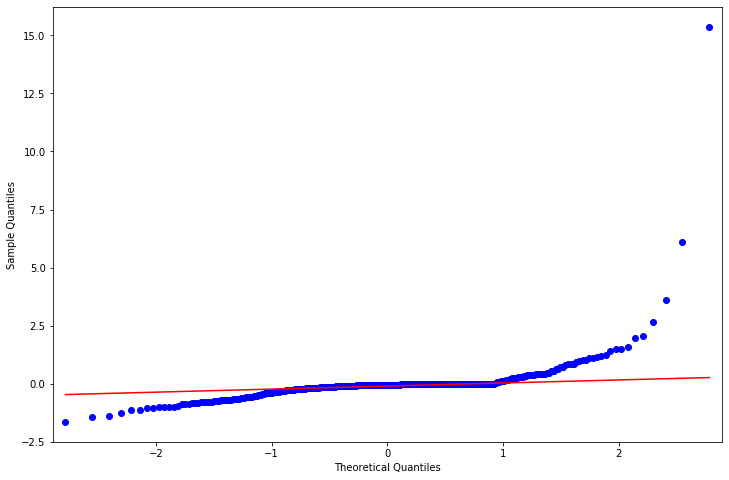

Prediction for one day later is: [0.01788432]
Let's plot predictions


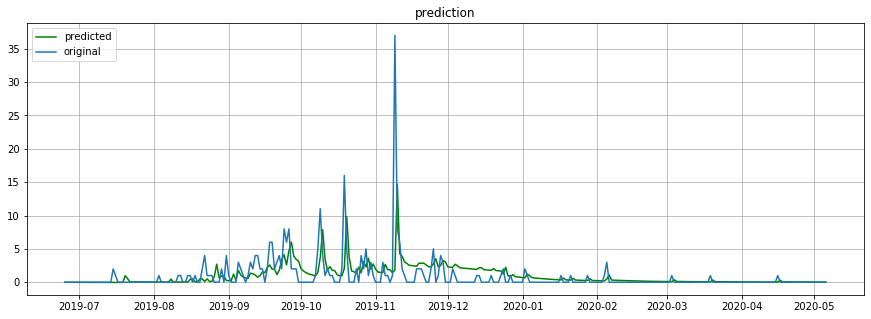

Statistical Evaluation
ARIMA(1,1,1): 
	r^2=0.091651
	MAE=1.027228
	MAPE=inf


{'Bikini_Top': [0], 'Jacket': [0]}

In [38]:
pred = arima_one_by_one(Jacket, 'sold_count', 1,1,1)
result_dict['Jacket'] = [int(round(pred))]
result_dict

In [40]:
apply_auto_arima_all_data(Facial_Cleanser, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=3464.768, BIC=3496.119, Time=0.267 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=3529.588, BIC=3537.426, Time=0.014 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=3517.960, BIC=3533.635, Time=0.145 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=3511.390, BIC=3527.066, Time=0.150 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=3527.619, BIC=3531.538, Time=0.011 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=3460.988, BIC=3488.420, Time=0.232 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=3462.458, BIC=3485.971, Time=0.113 seconds
Fit ARIMA(2,1,2)x(0,0,2,12) [intercept=True]; AIC=3463.285, BIC=3494.637, Time=0.538 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=3462.918, BIC=3490.350, Time=0.312 seconds
Fit ARIMA(2,1,2)x(1,0,2,12) [intercept=True]; AIC=3466.400, BIC=3501.670, Time=0.639 seconds
Fit ARIMA(1,1,2)x(0,0,1,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=601.4768051539513, pvalue=2.460204816563988e-131)

Lets check QQPlot to observe if residuals have normal distribution?


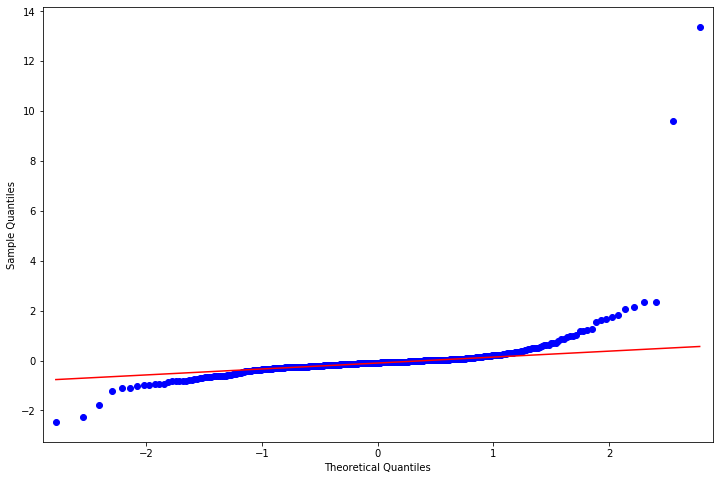

Prediction for one day later is: [75.00364025]
Let's plot predictions


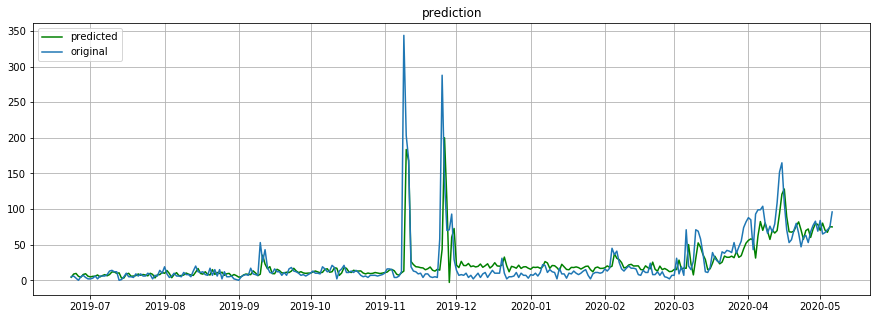

Statistical Evaluation
ARIMA(0,1,3): 
	r^2=0.497837
	MAE=10.855468
	MAPE=inf


{'Bikini_Top': [0], 'Jacket': [0], 'Facial_Cleanser': [75]}

In [41]:
pred = arima_one_by_one(Facial_Cleanser, 'sold_count', 0,1,3)
result_dict['Facial_Cleanser'] = [int(round(pred))]
result_dict

In [42]:
apply_auto_arima_all_data(Vacuum_Cleaner, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=3532.585, BIC=3563.936, Time=0.327 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=3653.611, BIC=3661.449, Time=0.017 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=3598.192, BIC=3613.867, Time=0.166 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=3543.839, BIC=3559.514, Time=0.174 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=3651.676, BIC=3655.595, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=3530.696, BIC=3558.128, Time=0.322 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=3528.736, BIC=3552.249, Time=0.153 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=3530.814, BIC=3558.247, Time=0.338 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=3527.856, BIC=3547.451, Time=0.127 seconds
Fit ARIMA(1,1,2)x(1,0,0,12) [intercept=True]; AIC=3534.377, BIC=3557.890, Time=0.258 seconds
Fit ARIMA(1,1,2)x(0,0,1,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=660.542326428703, pvalue=3.67329903093127e-144)

Lets check QQPlot to observe if residuals have normal distribution?


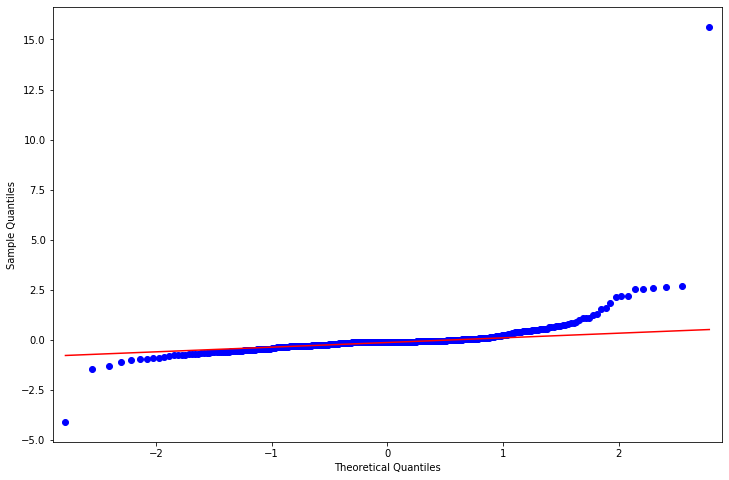

Prediction for one day later is: [114.7406844]
Let's plot predictions


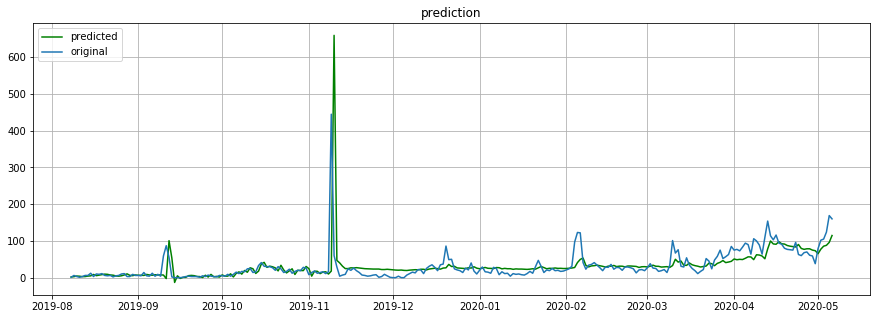

Statistical Evaluation
ARIMA(1,1,1): 
	r^2=-0.436640
	MAE=16.272689
	MAPE=inf


{'Bikini_Top': [0],
 'Jacket': [0],
 'Facial_Cleanser': [75],
 'Vacuum_Cleaner': [115]}

In [43]:
pred = arima_one_by_one(Vacuum_Cleaner, 'sold_count', 1,1,1)
result_dict['Vacuum_Cleaner'] = [int(round(pred))]
result_dict

In [44]:
apply_auto_arima_all_data(Phone_Bluetooth_Headset, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=5739.344, BIC=5770.695, Time=0.335 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=5820.296, BIC=5828.134, Time=0.014 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=5793.221, BIC=5808.897, Time=0.073 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=5769.744, BIC=5785.420, Time=0.129 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=5818.298, BIC=5822.217, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=5737.357, BIC=5764.790, Time=0.310 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=5735.369, BIC=5758.883, Time=0.146 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=5737.362, BIC=5764.794, Time=0.292 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=5738.678, BIC=5758.273, Time=0.126 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=5738.349, BIC=5757.943, Time=0.131 seconds
Fit ARIMA(3,1,2)x(0,0,0,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=420.59802455397585, pvalue=4.659071961744121e-92)

Lets check QQPlot to observe if residuals have normal distribution?


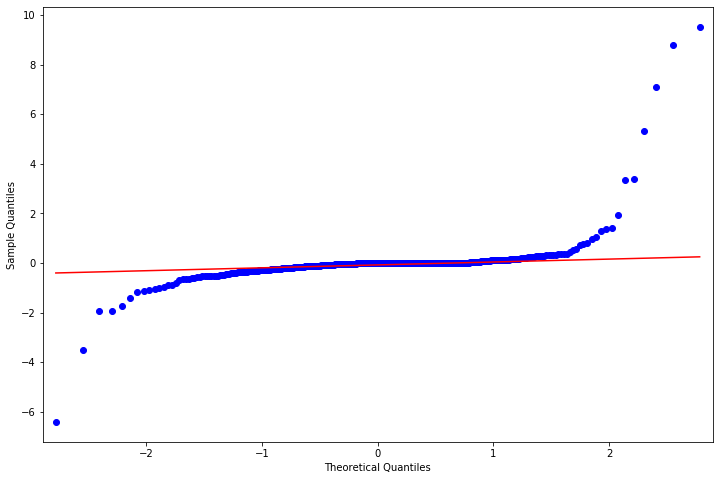

Prediction for one day later is: [366.76855069]
Let's plot predictions


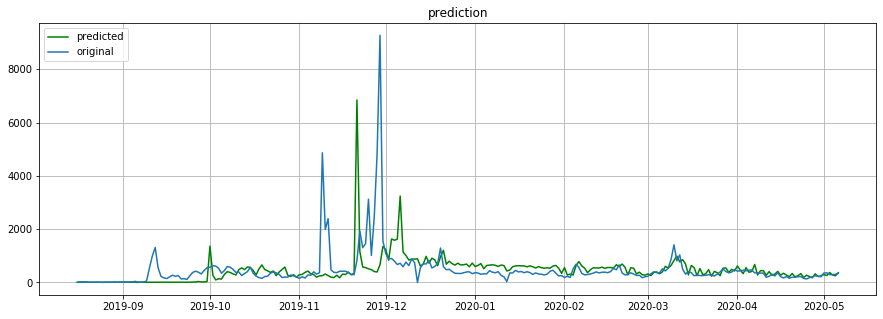

Statistical Evaluation
ARIMA(3,1,3): 
	r^2=-0.262852
	MAE=316.355386
	MAPE=inf


{'Bikini_Top': [0],
 'Jacket': [0],
 'Facial_Cleanser': [75],
 'Vacuum_Cleaner': [115],
 'Phone_Bluetooth_Headset': [367]}

In [45]:
pred = arima_one_by_one(Phone_Bluetooth_Headset, 'sold_count', 3,1,3)
result_dict['Phone_Bluetooth_Headset'] = [int(round(pred))]
result_dict

In [46]:
apply_auto_arima_all_data(Wet_Wipes_Towel, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=5304.336, BIC=5335.688, Time=0.413 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=5420.510, BIC=5428.348, Time=0.017 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=5346.171, BIC=5361.846, Time=0.198 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=5359.038, BIC=5374.714, Time=0.186 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=5418.513, BIC=5422.432, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=5302.093, BIC=5329.526, Time=0.355 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=5305.833, BIC=5329.346, Time=0.176 seconds
Fit ARIMA(2,1,2)x(0,0,2,12) [intercept=True]; AIC=5304.416, BIC=5335.767, Time=0.907 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=5301.842, BIC=5329.275, Time=0.473 seconds
Fit ARIMA(2,1,2)x(2,0,0,12) [intercept=True]; AIC=5303.873, BIC=5335.224, Time=0.782 seconds
Fit ARIMA(2,1,2)x(2,0,1,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=422.9522969902207, pvalue=1.4357395184596372e-92)

Lets check QQPlot to observe if residuals have normal distribution?


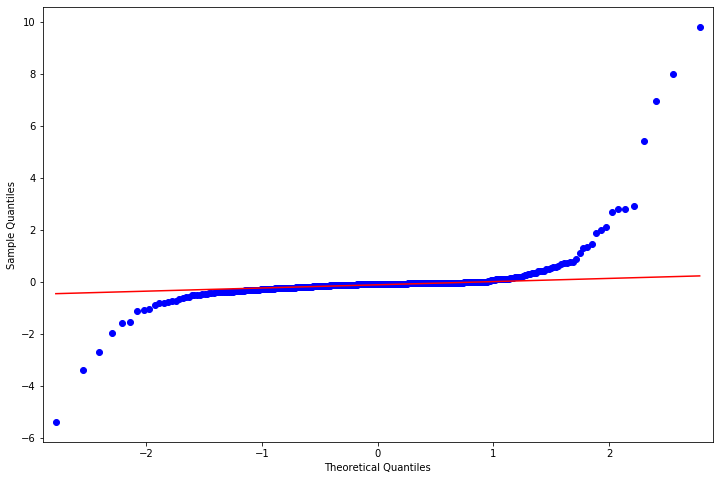

Prediction for one day later is: [206.15691897]
Let's plot predictions


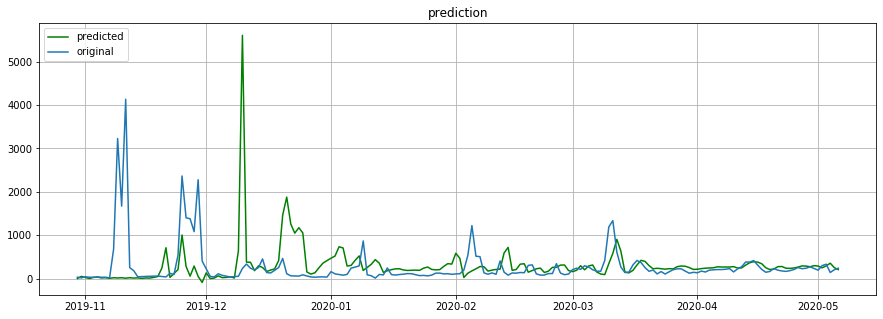

Statistical Evaluation
ARIMA(3,1,2): 
	r^2=-0.946839
	MAE=285.636422
	MAPE=194.258806


{'Bikini_Top': [0],
 'Jacket': [0],
 'Facial_Cleanser': [75],
 'Vacuum_Cleaner': [115],
 'Phone_Bluetooth_Headset': [367],
 'Wet_Wipes_Towel': [206]}

In [47]:
pred = arima_one_by_one(Wet_Wipes_Towel, 'sold_count', 3,1,2)
result_dict['Wet_Wipes_Towel'] = [int(round(pred))]
result_dict

In [48]:
apply_auto_arima_all_data(Rechargeable_Toothbrush, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=3968.796, BIC=4000.147, Time=0.314 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=4027.544, BIC=4035.382, Time=0.016 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=3994.890, BIC=4010.566, Time=0.085 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=3989.785, BIC=4005.461, Time=0.181 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=4025.590, BIC=4029.509, Time=0.014 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=3965.632, BIC=3993.065, Time=0.278 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=3965.634, BIC=3989.147, Time=0.149 seconds
Fit ARIMA(2,1,2)x(0,0,2,12) [intercept=True]; AIC=3963.435, BIC=3994.786, Time=0.860 seconds
Fit ARIMA(2,1,2)x(1,0,2,12) [intercept=True]; AIC=3963.032, BIC=3998.302, Time=0.893 seconds
Fit ARIMA(2,1,2)x(2,0,2,12) [intercept=True]; AIC=3964.555, BIC=4003.744, Time=1.064 seconds
Fit ARIMA(2,1,2)x(2,0,1,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=565.5451014222023, pvalue=1.561139068867861e-123)

Lets check QQPlot to observe if residuals have normal distribution?


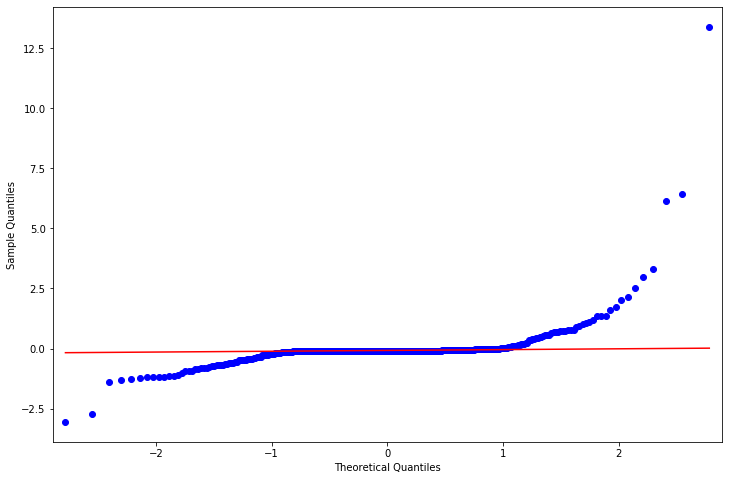

Prediction for one day later is: [176.92350671]
Let's plot predictions


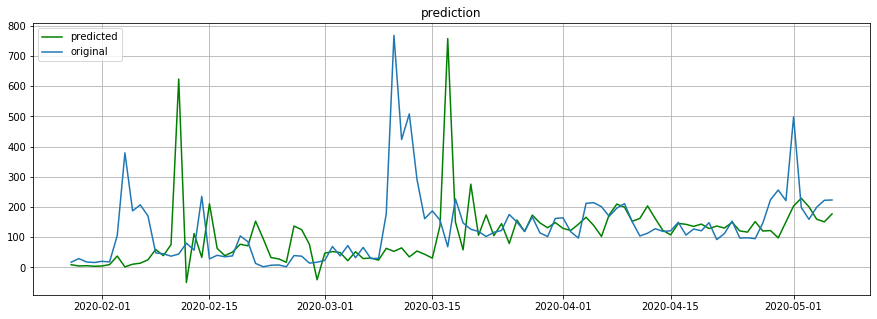

Statistical Evaluation
ARIMA(1,1,5): 
	r^2=-0.798026
	MAE=82.602341
	MAPE=151.412165


{'Bikini_Top': [0],
 'Jacket': [0],
 'Facial_Cleanser': [75],
 'Vacuum_Cleaner': [115],
 'Phone_Bluetooth_Headset': [367],
 'Wet_Wipes_Towel': [206],
 'Rechargeable_Toothbrush': [177]}

In [49]:
pred = arima_one_by_one(Rechargeable_Toothbrush, 'sold_count', 1,1,5)
result_dict['Rechargeable_Toothbrush'] = [int(round(pred))]
result_dict

In [50]:
apply_auto_arima_all_data(Tights, 'sold_count')

Performing stepwise search to minimize aic
Fit ARIMA(2,1,2)x(1,0,1,12) [intercept=True]; AIC=4932.724, BIC=4964.076, Time=0.317 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=True]; AIC=4978.511, BIC=4986.349, Time=0.012 seconds
Fit ARIMA(1,1,0)x(1,0,0,12) [intercept=True]; AIC=4964.242, BIC=4979.917, Time=0.104 seconds
Fit ARIMA(0,1,1)x(0,0,1,12) [intercept=True]; AIC=4956.928, BIC=4972.604, Time=0.088 seconds
Fit ARIMA(0,1,0)x(0,0,0,12) [intercept=False]; AIC=4976.514, BIC=4980.433, Time=0.013 seconds
Fit ARIMA(2,1,2)x(0,0,1,12) [intercept=True]; AIC=4931.013, BIC=4958.446, Time=0.257 seconds
Fit ARIMA(2,1,2)x(0,0,0,12) [intercept=True]; AIC=4926.925, BIC=4950.438, Time=0.139 seconds
Fit ARIMA(2,1,2)x(1,0,0,12) [intercept=True]; AIC=4929.410, BIC=4956.842, Time=0.274 seconds
Fit ARIMA(1,1,2)x(0,0,0,12) [intercept=True]; AIC=4943.876, BIC=4963.471, Time=0.106 seconds
Fit ARIMA(2,1,1)x(0,0,0,12) [intercept=True]; AIC=4939.434, BIC=4959.029, Time=0.105 seconds
Fit ARIMA(3,1,2)x(0,0,0,12

With the latest model: 

What is the Normal Distribution test result? 
- NormaltestResult(statistic=266.6450635438432, pvalue=1.2553364467725042e-58)

Lets check QQPlot to observe if residuals have normal distribution?


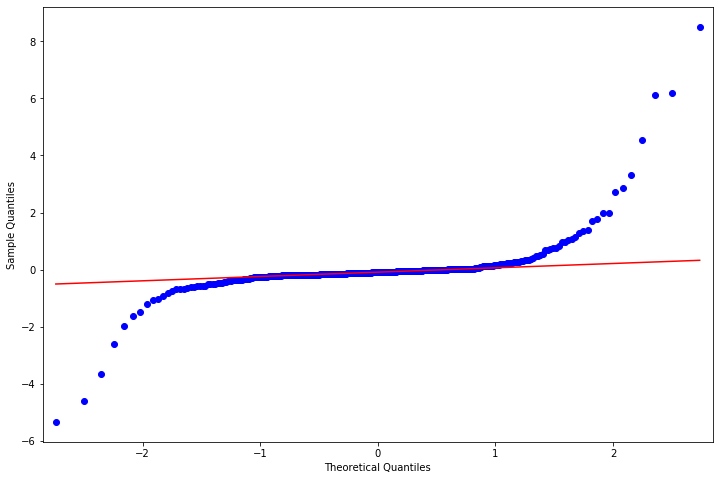

Prediction for one day later is: [468.88927839]
Let's plot predictions


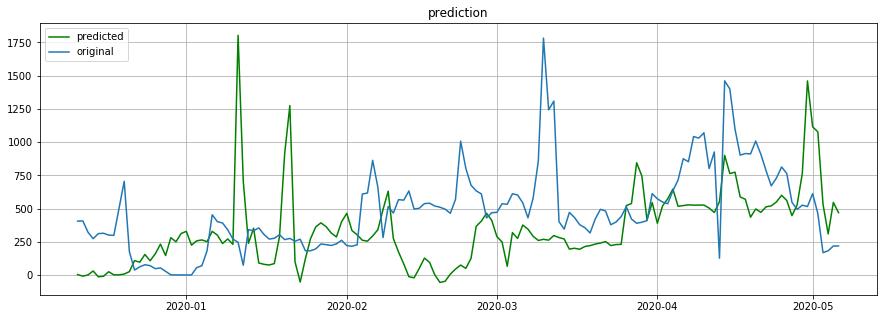

Statistical Evaluation
ARIMA(2,1,2): 
	r^2=-0.673670
	MAE=310.948768
	MAPE=inf


{'Bikini_Top': [0],
 'Jacket': [0],
 'Facial_Cleanser': [75],
 'Vacuum_Cleaner': [115],
 'Phone_Bluetooth_Headset': [367],
 'Wet_Wipes_Towel': [206],
 'Rechargeable_Toothbrush': [177],
 'Tights': [469]}

In [51]:
pred = arima_one_by_one(Tights, 'sold_count', 2,1,2)
result_dict['Tights'] = [int(round(pred))]
result_dict

In [52]:
preds = pd.DataFrame.from_dict(result_dict).T.reset_index().rename(columns = {'index':'Bottom_Hier', 0:'predictions'})
preds

,Bottom_Hier,predictions
0,Bikini_Top,0
1,Jacket,0
2,Facial_Cleanser,75
3,Vacuum_Cleaner,115
4,Phone_Bluetooth_Headset,367
5,Wet_Wipes_Towel,206
6,Rechargeable_Toothbrush,177
7,Tights,469


Above data table shows my final predictions for each product.